# Using `gwent` to Calculate Signal-to-Noise Ratios

Here we present a tutorial on how to use `gwent` to calculate SNRs for the instrument models currently implemented (LISA, PTAs, aLIGO, and Einstein Telescope) with the signal being an array of coalescing Binary Black Holes.

First, we import important modules.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import astropy.constants as const
import time
import astropy.units as u

import os,sys
current_path = os.getcwd()
splt_path = current_path.split("/")
top_path_idx = splt_path.index('gwent')
top_directory = "/".join(splt_path[0:top_path_idx+1])

sys.path.insert(0,top_directory)
import gwent
import gwent.binary as binary
import gwent.detector as detector
import gwent.snr as snr
import gwent.snrplot as snrplot

Setting matplotlib preferences

In [3]:
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['figure.figsize'] = [5,3]
mpl.rcParams['text.usetex'] = True
mpl.rc('font',**{'family':'serif','serif':['Times New Roman'],'size':14})

We need to get the file directories to load in the instrument files.

In [4]:
load_directory = gwent.__path__[0] + '/LoadFiles/InstrumentFiles/'

## Source Selection Function

Takes in a an instrument model that dictates reasonable mass ranges for the particular detector mass regime and instantiates a source with the variable ranges limited by the waveform calibration region.

The source parameters must be set (ie. M,q,z,chi1,chi2), but one only needs to set the minima and maxima of the selected SNR axes variables.

In [5]:
def Get_Source(model):
    if model in [0,1]:
        #M = m1+m2 Total Mass
        M = 1e2
        M_min = 1e0
        M_max = 1e5
    elif model in [2,3,4,5,6]:
        #M = m1+m2 Total Mass
        M = 1e9
        M_min = 1e8
        M_max = 1e11
    else:
        #M = m1+m2 Total Mass
        M = 1e6
        M_min = 1e1
        M_max = 1e10
        
    #q = m2/m1 reduced mass
    q = 1.0
    q_min = 1.0
    q_max = 18.0

    #Chi = S_i*L/m_i**2, spins of each mass i
    chi1 = 0.0 #spin of m1
    chi2 = 0.0 #spin of m2
    chi_min = -0.85 #Limits of PhenomD for unaligned spins
    chi_max = 0.85
    
    z = 1.0 #Redshift
    z_min = 1e-2
    z_max = 1e3
    
    source = binary.BBHFrequencyDomain(M,q,z,chi1,chi2)
    source.M = [M,M_min,M_max]
    source.q = [q,q_min,q_max]
    source.chi1 = [chi1,chi_min,chi_max]
    source.chi2 = [chi2,chi_min,chi_max]
    source.z = [z,z_min,z_max]

    return source

## Instrument Selection Function

Takes in an instrument model then assigns the fiducial noise and detector values. The model only assigns ranges of calculation for quick variable calculations, but one only needs to set the minima and maxima if they wish to use other selected SNR axes variables.

If loading a detector, the file should be frequency in the first column and either strain, effective strain noise spectral density, or amplitude spectral density in the second column.

For generating a detector, one must assign a value to each of the different instrument parameters (see the section on Declaring x and y variables and Sample Rates).

In [6]:
def Get_Instrument(model):
    if model in [0,1]:
        T_obs = 4*u.yr #Observing time in years
        if model == 0: #Einstein Telescope
            #Loaded from http://www.et-gw.eu/index.php/etsensitivities
            load_name = 'ET_D_data.txt'
            load_location = load_directory + 'EinsteinTelescope/' + load_name
            instrument = detector.GroundBased('ET',T_obs,load_location=load_location,I_type='A')
        elif model == 1: #aLIGO
            #Loaded from https://dcc.ligo.org/T1800044/public
            load_name = 'aLIGODesign.txt'
            load_location = load_directory + 'aLIGO/' + load_name
            instrument = detector.GroundBased('aLIGO',T_obs,load_location=load_location,I_type='A')
    elif model in [2,3,4]:
        #NANOGrav calculation using 11.5yr parameters https://arxiv.org/abs/1801.01837
        T_obs = 15*u.yr #Observing time in years
        T_obs_min = 5*u.yr
        T_obs_max = 30*u.yr
        
        sigma = 100*u.ns.to('s')*u.s #rms timing residuals in seconds
        sigma_min = 100*u.ns.to('s')*u.s
        sigma_max = 500*u.ns.to('s')*u.s
        
        N_p = 18 #Number of pulsars
        N_p_min = 18
        N_p_max = 40
        
        cadence = 1/(2*u.wk.to('yr')*u.yr) #Avg observation cadence of 1 every 2 weeks in num/year
        cadence_min = 2/u.yr
        cadence_max = 1/(u.wk.to('yr')*u.yr)
        
        
        if model == 2: #NANOGrav 15 yr WN only
            instrument = detector.PTA('NANOGrav_WN',T_obs,N_p,sigma,cadence)
        elif model == 3: #NANOGrav realistic noise
            instrument = detector.PTA('NANOGrav_realistic_noise',T_obs,N_p,cadence,use_11yr=True)
        elif model == 4: #NANOGrav 11 yr real data
            #NANOGrav calculation using 11.5yr parameters https://arxiv.org/abs/1801.01837
            load_name = 'NANOGrav_11yr_S_eff.txt'
            load_location = load_directory + 'NANOGrav/StrainFiles/' + load_name
            T_obs = 11.42*u.yr #Observing time in years
            instrument = detector.PTA('NANOGrav_11yr',load_location=load_location,I_type='E')
            
        instrument.T_obs = [T_obs,T_obs_min,T_obs_max]
        instrument.sigma = [sigma,sigma_min,sigma_max]
        instrument.N_p = [N_p,N_p_min,N_p_max]
        instrument.cadence = [cadence,cadence_min,cadence_max]
        
    elif model in [5,6]: #SKA (2030s)
        #SKA calculation using parameters and methods from https://arxiv.org/abs/0804.4476 section 7.1
        T_obs = 15*u.yr #Observing time (years)
        T_obs_min = 10*u.yr
        T_obs_max = 30*u.yr
        
        sigma = 10*u.ns.to('s')*u.s #rms timing residuals in nanoseconds
        sigma_min = 10*u.ns.to('s')*u.s
        sigma_max = 100*u.ns.to('s')*u.s
        
        N_p = 20 #Number of pulsars
        N_p_min = 18
        N_p_max = 200
        
        cadence = 1/(u.wk.to('yr')*u.yr) #Avg observation cadence of 1 every week in num/year
        cadence_min = 2/u.yr
        cadence_max = 1/(u.wk.to('yr')*u.yr)
        
        if model == 5: #SKA WN only
            instrument = detector.PTA('SKA_WN',T_obs,N_p,sigma,cadence)
        elif model == 6: #SKA realistic noise
            instrument = detector.PTA('SKA_realistic_noise',T_obs,N_p,cadence,use_11yr=True)
            
        instrument.T_obs = [T_obs,T_obs_min,T_obs_max]
        instrument.sigma = [sigma,sigma_min,sigma_max]
        instrument.N_p = [N_p,N_p_min,N_p_max]
        instrument.cadence = [cadence,cadence_min,cadence_max]
        
    else:
        #L3 proposal
        #Default Params from https://arxiv.org/abs/1702.00786
        
        T_obs = 4*u.yr #Observing time in years
        T_obs_min = 1*u.yr
        T_obs_max = 10*u.yr

        L = 2.5e9*u.m #armlength in meters
        L_min = 1.0e7*u.m
        L_max = 1.0e11*u.m
        
        A_acc = 3e-15*u.m/u.s/u.s
        A_acc_min = 1e-16*u.m/u.s/u.s
        A_acc_max = 1e-14*u.m/u.s/u.s
        
        f_acc_break_low = .4*u.mHz.to('Hz')*u.Hz
        f_acc_break_low_min = .1*u.mHz.to('Hz')*u.Hz
        f_acc_break_low_max = 1.0*u.mHz.to('Hz')*u.Hz
        
        f_acc_break_high = 8.*u.mHz.to('Hz')*u.Hz
        f_acc_break_high_min = 1.*u.mHz.to('Hz')*u.Hz
        f_acc_break_high_max = 10.*u.mHz.to('Hz')*u.Hz
        
        f_IFO_break = 2.*u.mHz.to('Hz')*u.Hz
        f_IFO_break_min = 1.*u.mHz.to('Hz')*u.Hz
        f_IFO_break_max = 5.*u.mHz.to('Hz')*u.Hz
        
        A_IFO = 10e-12*u.m
        A_IFO_min = 1.0e-12*u.m
        A_IFO_max = 2.0e-11*u.m
        
        Background = False
        T_type = 'N'

        instrument = detector.SpaceBased('LISA_ESA',\
                                       T_obs,L,A_acc,f_acc_break_low,f_acc_break_high,A_IFO,f_IFO_break,\
                                       Background=Background,T_type=T_type)
            
        instrument.T_obs = [T_obs,T_obs_min,T_obs_max]
        instrument.L = [L,L_min,L_max]
        instrument.A_acc = [A_acc,A_acc_min,A_acc_max]
        instrument.f_acc_break_low = [f_acc_break_low,f_acc_break_low_min,f_acc_break_low_max]
        instrument.f_acc_break_high = [f_acc_break_high,f_acc_break_high_min,f_acc_break_high_max]
        instrument.A_IFO = [A_IFO,A_IFO_min,A_IFO_max]
        instrument.f_IFO_break = [f_IFO_break,f_IFO_break_min,f_IFO_break_max]
        
    return instrument

## Declaring x and y variables and Sample Rates

The variables for either axis in the SNR calculation can be:

* GLOBAL:

    * 'T_obs' - Detector Observation Time
    
* SOURCE:

    * 'M' - Mass (Solar Units)
    * 'q' - Mass Ratio
    * 'chi1' - Dimensionless Spin of Black Hole 1
    * 'chi2' - Dimensionless Spin of Black Hole 2
    * 'z' - Redshift
    
* LISA ONLY:

    * 'L' - Detector Armlength
    * 'A_acc' - Detector Acceleration Noise
    * 'A_IMS' - Detector Optical Metrology Noise
    * 'f_acc_break_low' - The Low Acceleration Noise Break Frequency
    * 'f_acc_break_high' - The High Acceleration Noise Break Frequency
    * 'f_IMS_break' - The Optical Metrology Noise Break Frequency
    
* PTAs ONLY:

    * 'N_p' - Number of Pulsars
    * 'sigma' - Root-Mean-Squared Timing Error
    * 'cadence' - Observation Cadence

## SNR Calculation

Based on the selected model, we use `Get_Instrument` and `Get_Source` to instantiate both the instrument and the model for the SNR Calculation.

In [7]:
#Number of SNRMatrix rows
sampleRate_y = 75
#Number of SNRMatrix columns
sampleRate_x = 75
#Variable on y-axis
var_y = 'z'
#Variable on x-axis
var_x = 'M'
#Model for NANOGrav WN only
model = 2
instrument = Get_Instrument(model)
source = Get_Source(model)

We now use `Get_SNR_Matrix` with the variables given and the data range to sample the space either logrithmically or linearly based on the selection of variables. 
It computes the SNR for each value, then returns the variable ranges used to calculate the SNR for each matrix, then returns the SNRs with size of the `sampleRate1`X`sampleRate2`

In [8]:
start = time.time()
[sample_x,sample_y,SNRMatrix] = snr.Get_SNR_Matrix(source,instrument,var_x,sampleRate_x,var_y,sampleRate_y)
end = time.time()
print(end-start)

30.32592487335205


Plot the SNR using the initial variables and the returns from `Get_SNR_Matrix`

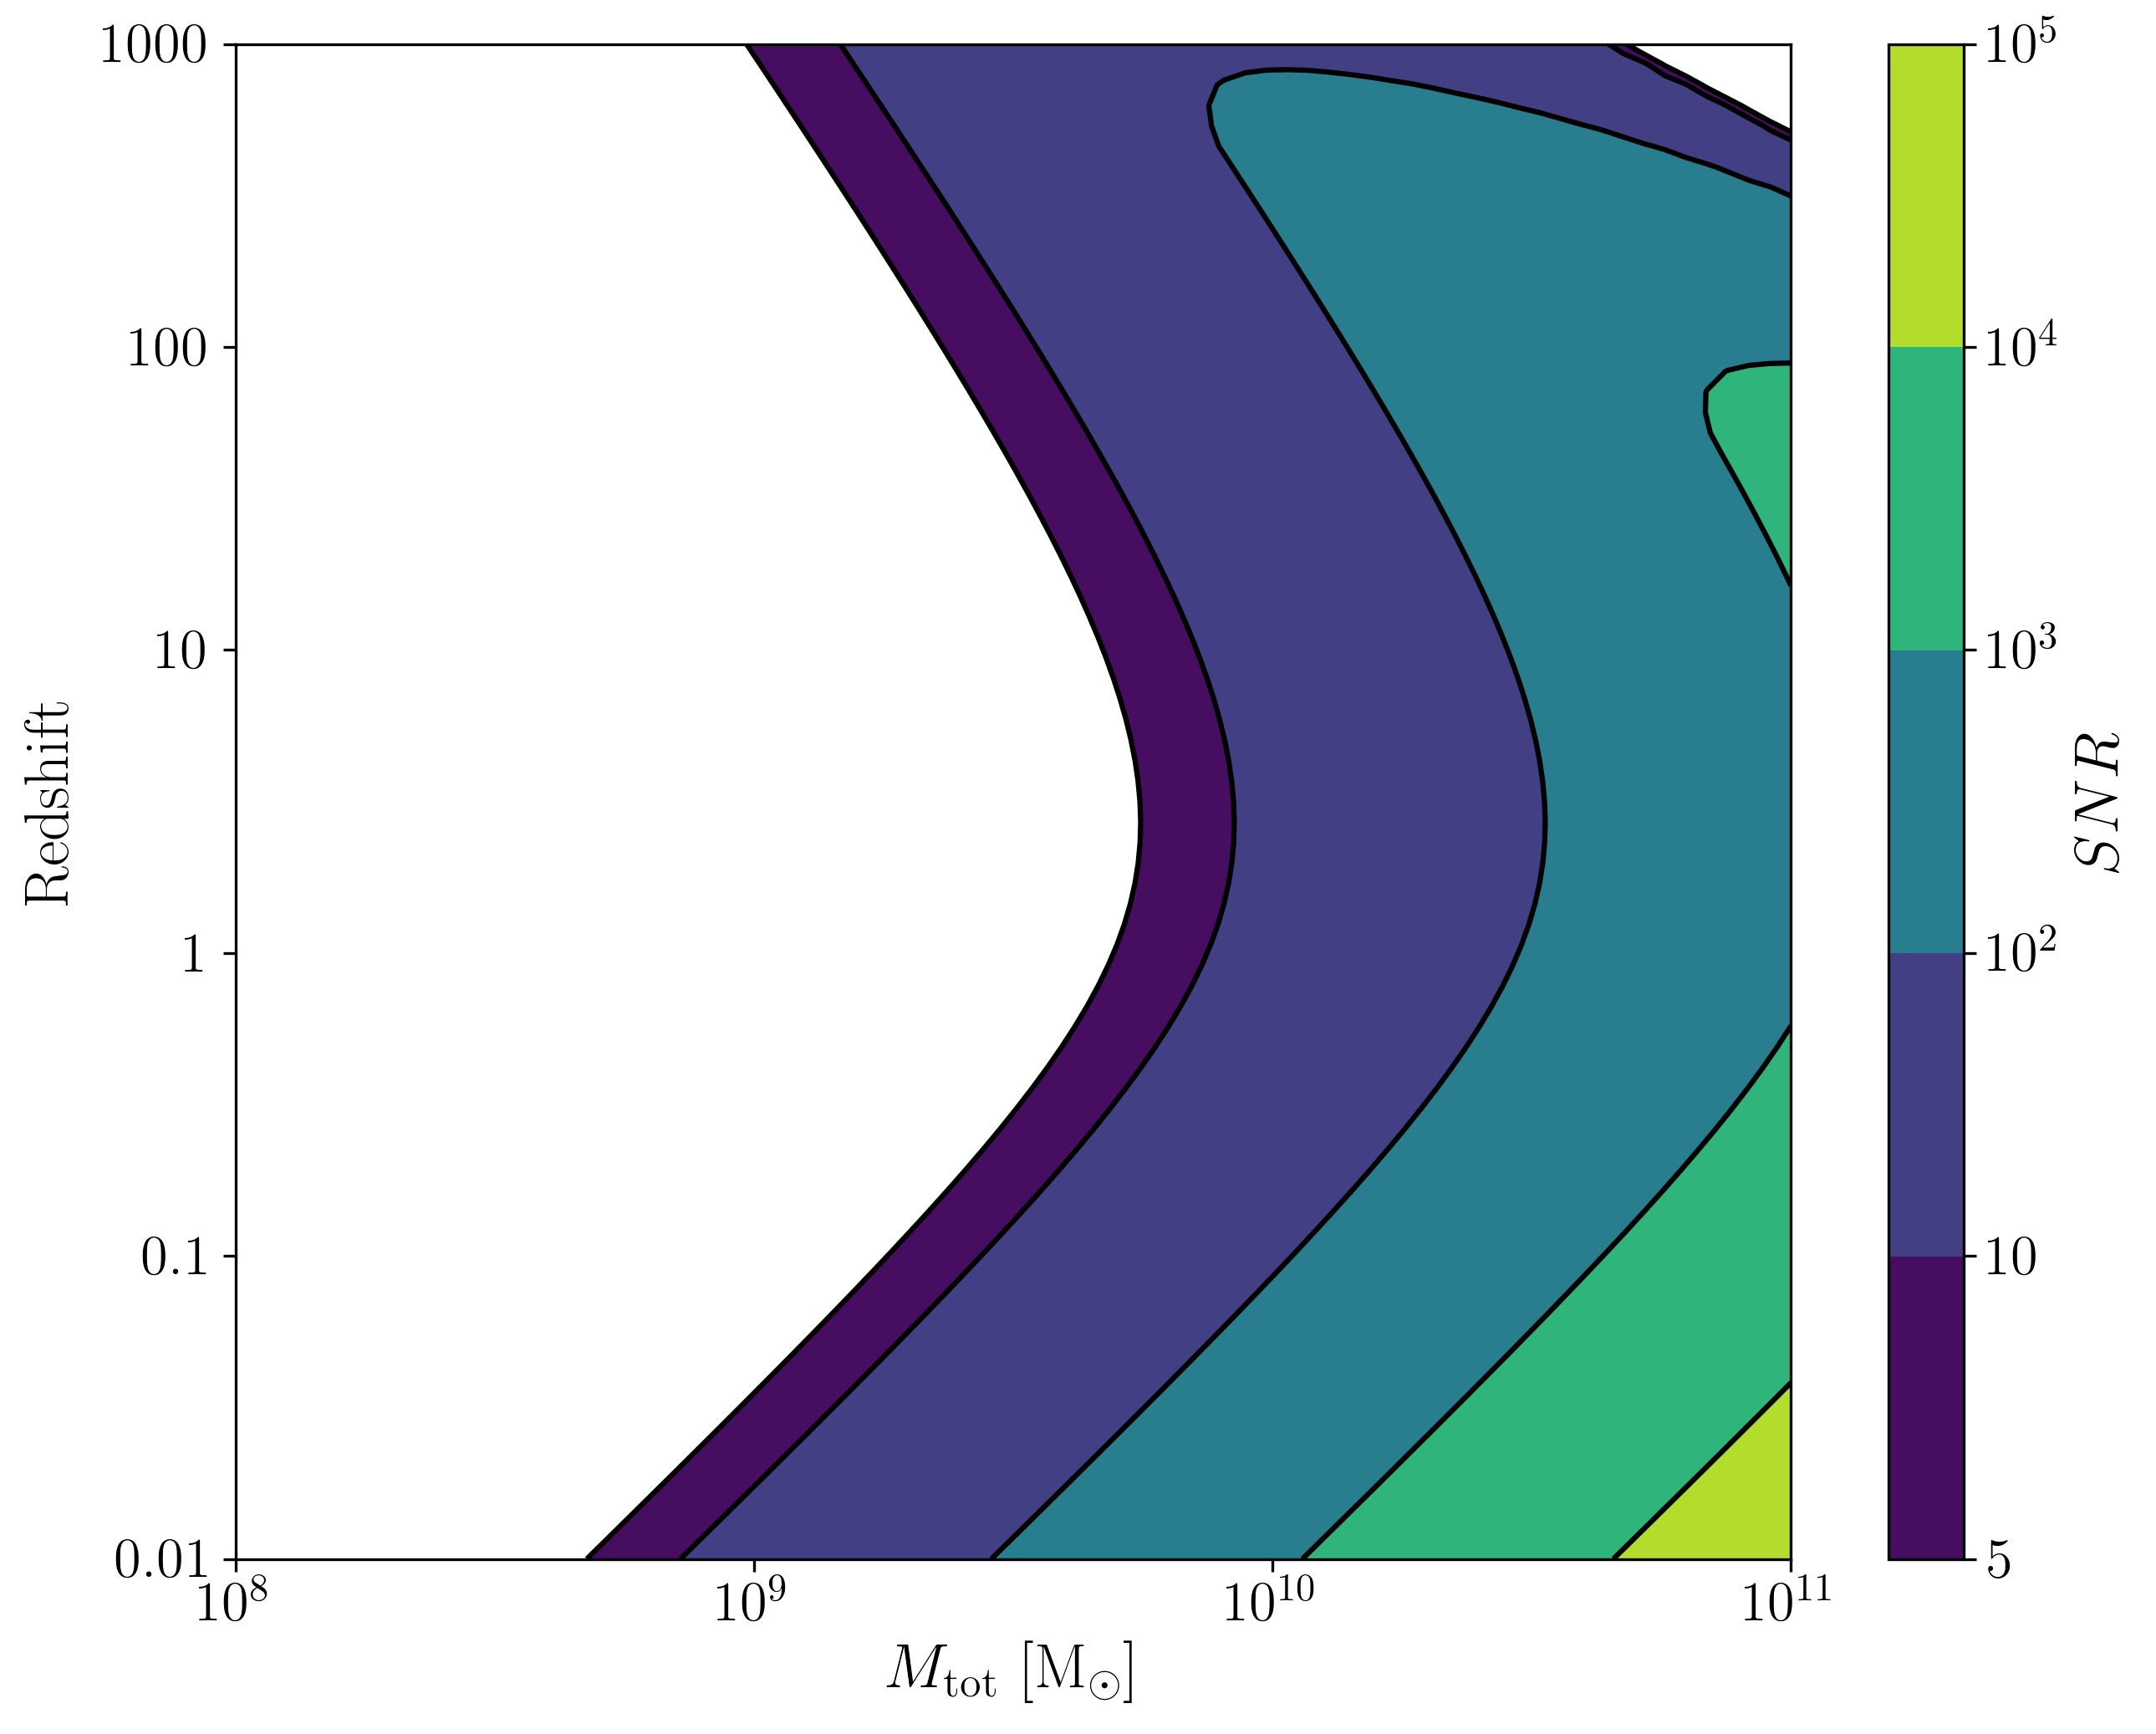

In [9]:
snrplot.Plot_SNR(source,instrument,var_x,sample_x,var_y,sample_y,SNRMatrix,smooth_contours=False)

## Create SNR Matrices and Samples for a Few Examples

### Ground Based Instruments

In [10]:
#Number of SNRMatrix rows
sampleRate_y = 50
#Number of SNRMatrix columns
sampleRate_x = 50
#Variable on y-axis
var_ys = ['z','q','chi2']
#Variable on x-axis
var_x = 'M'

#### Einstein Telescope

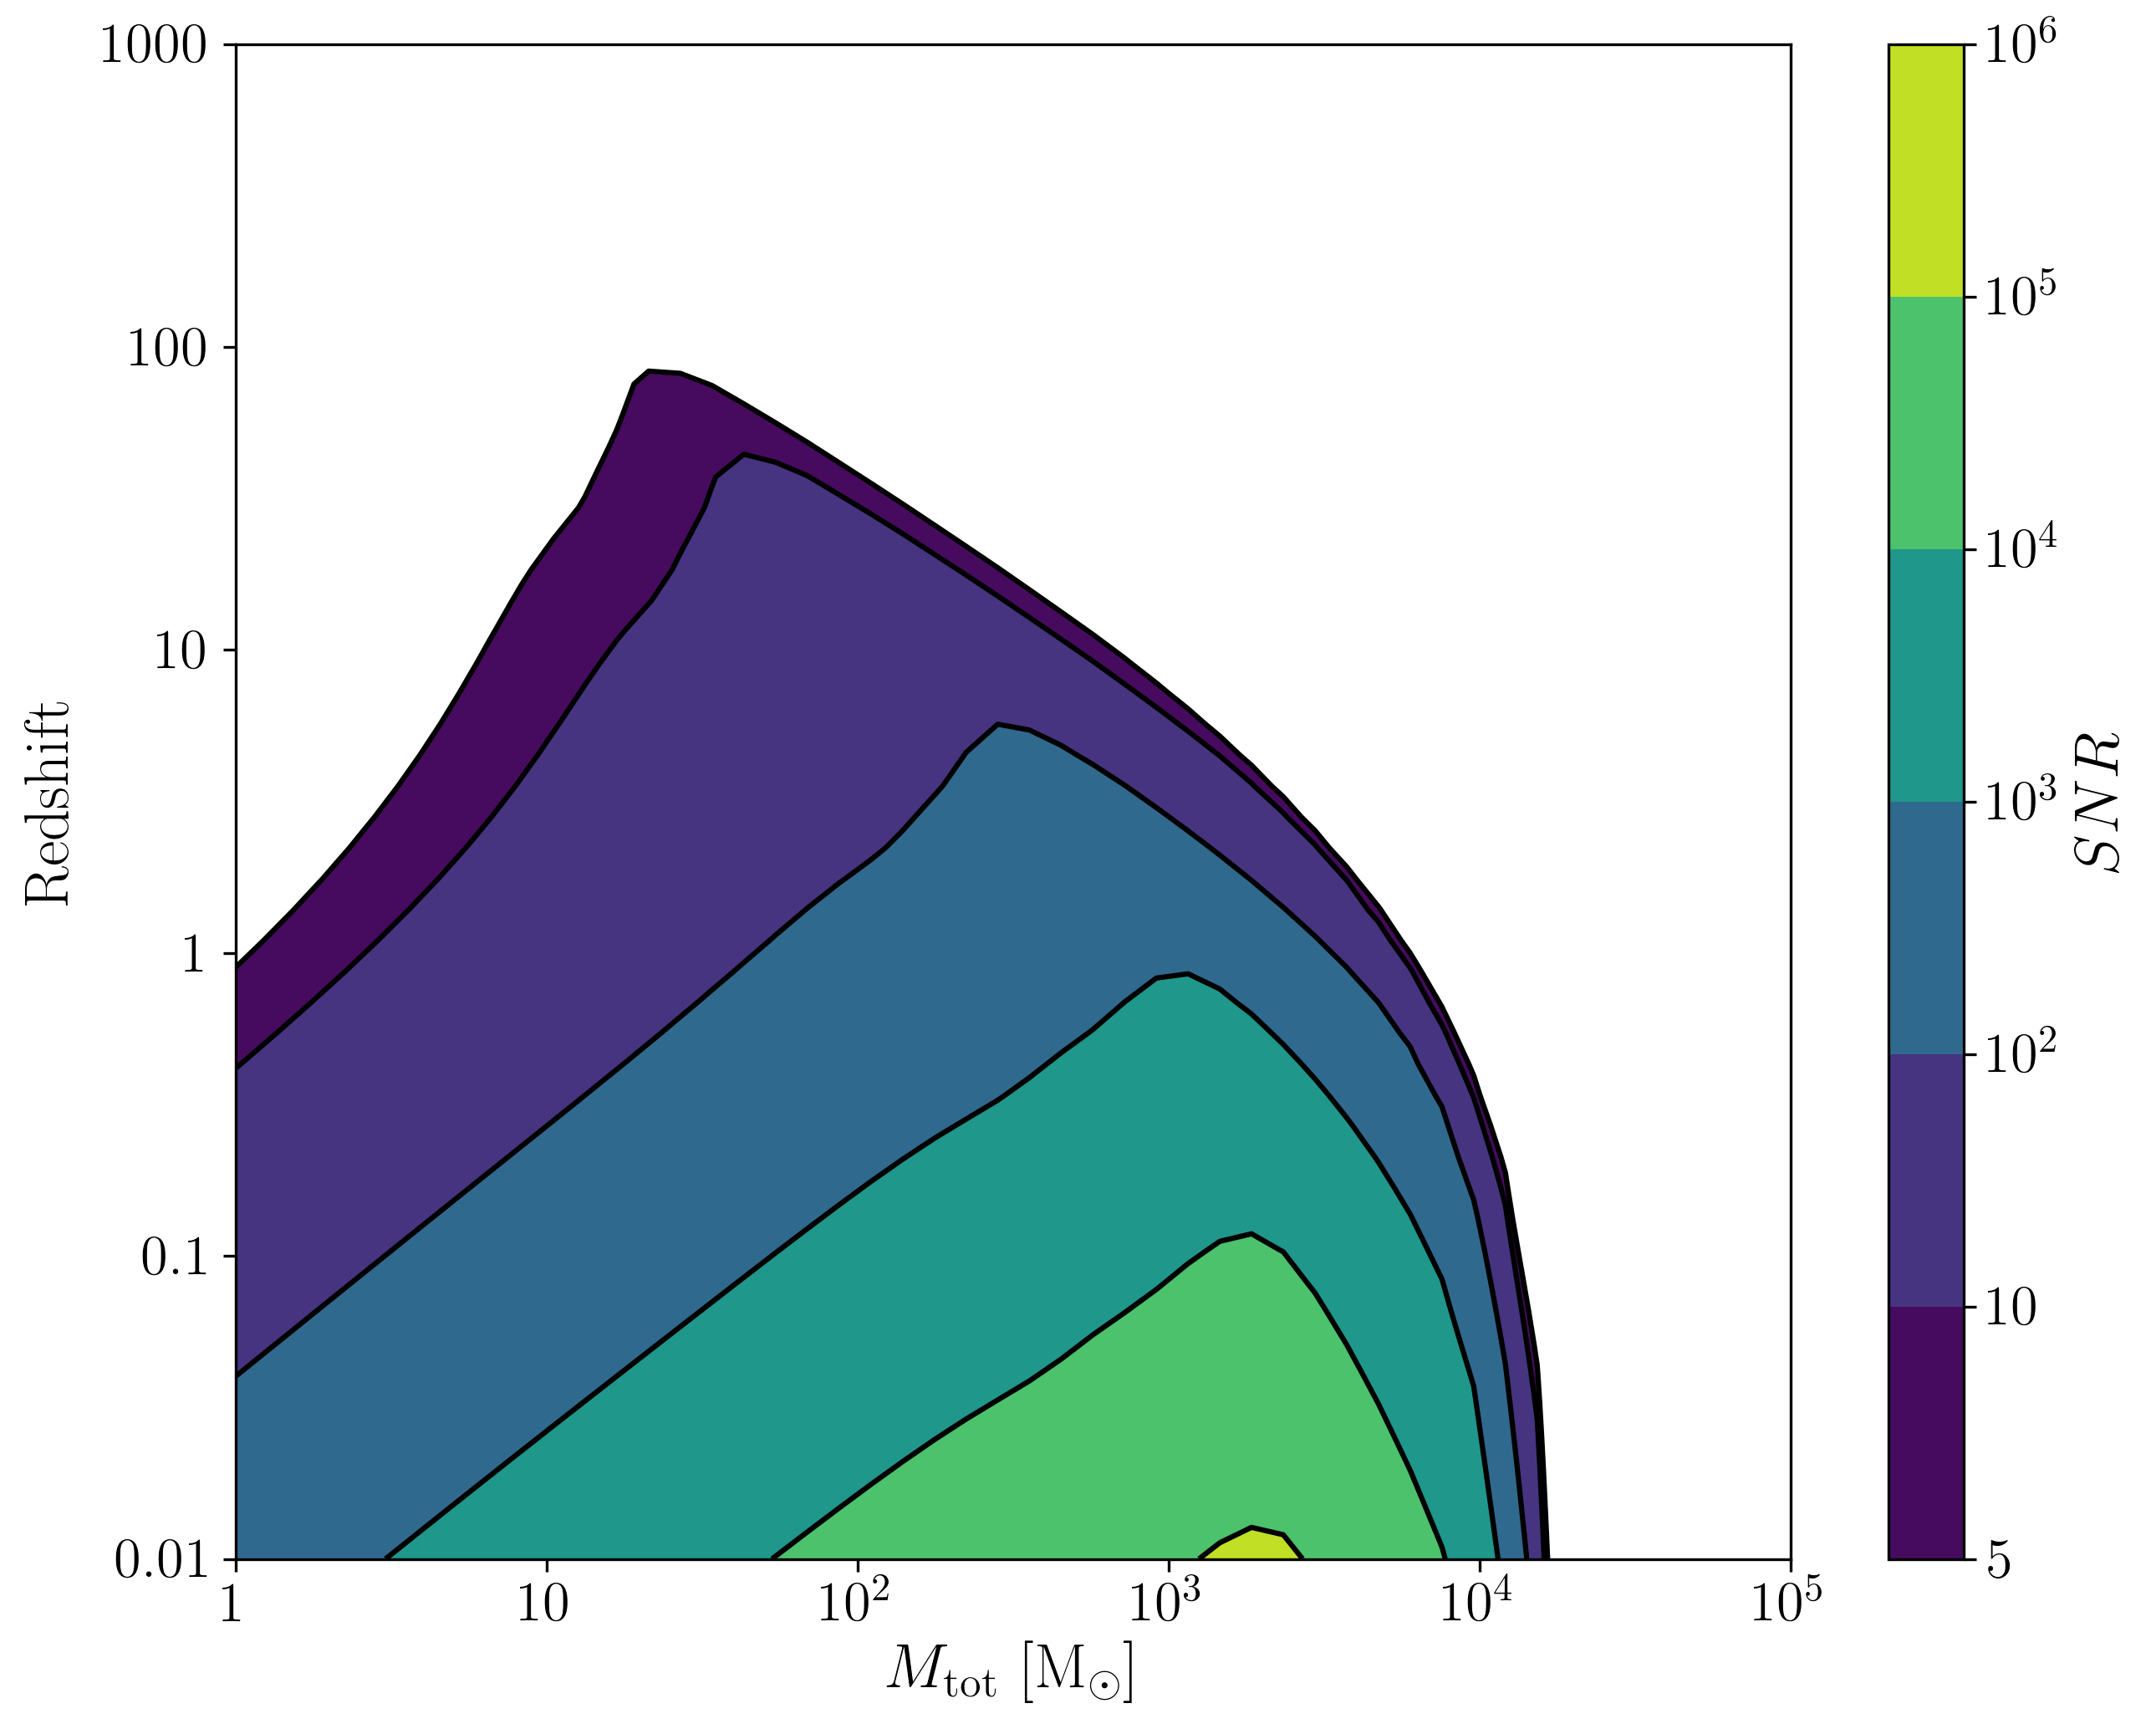

Model:  ET_M_vs_z ,  done. t = :  16.7746262550354


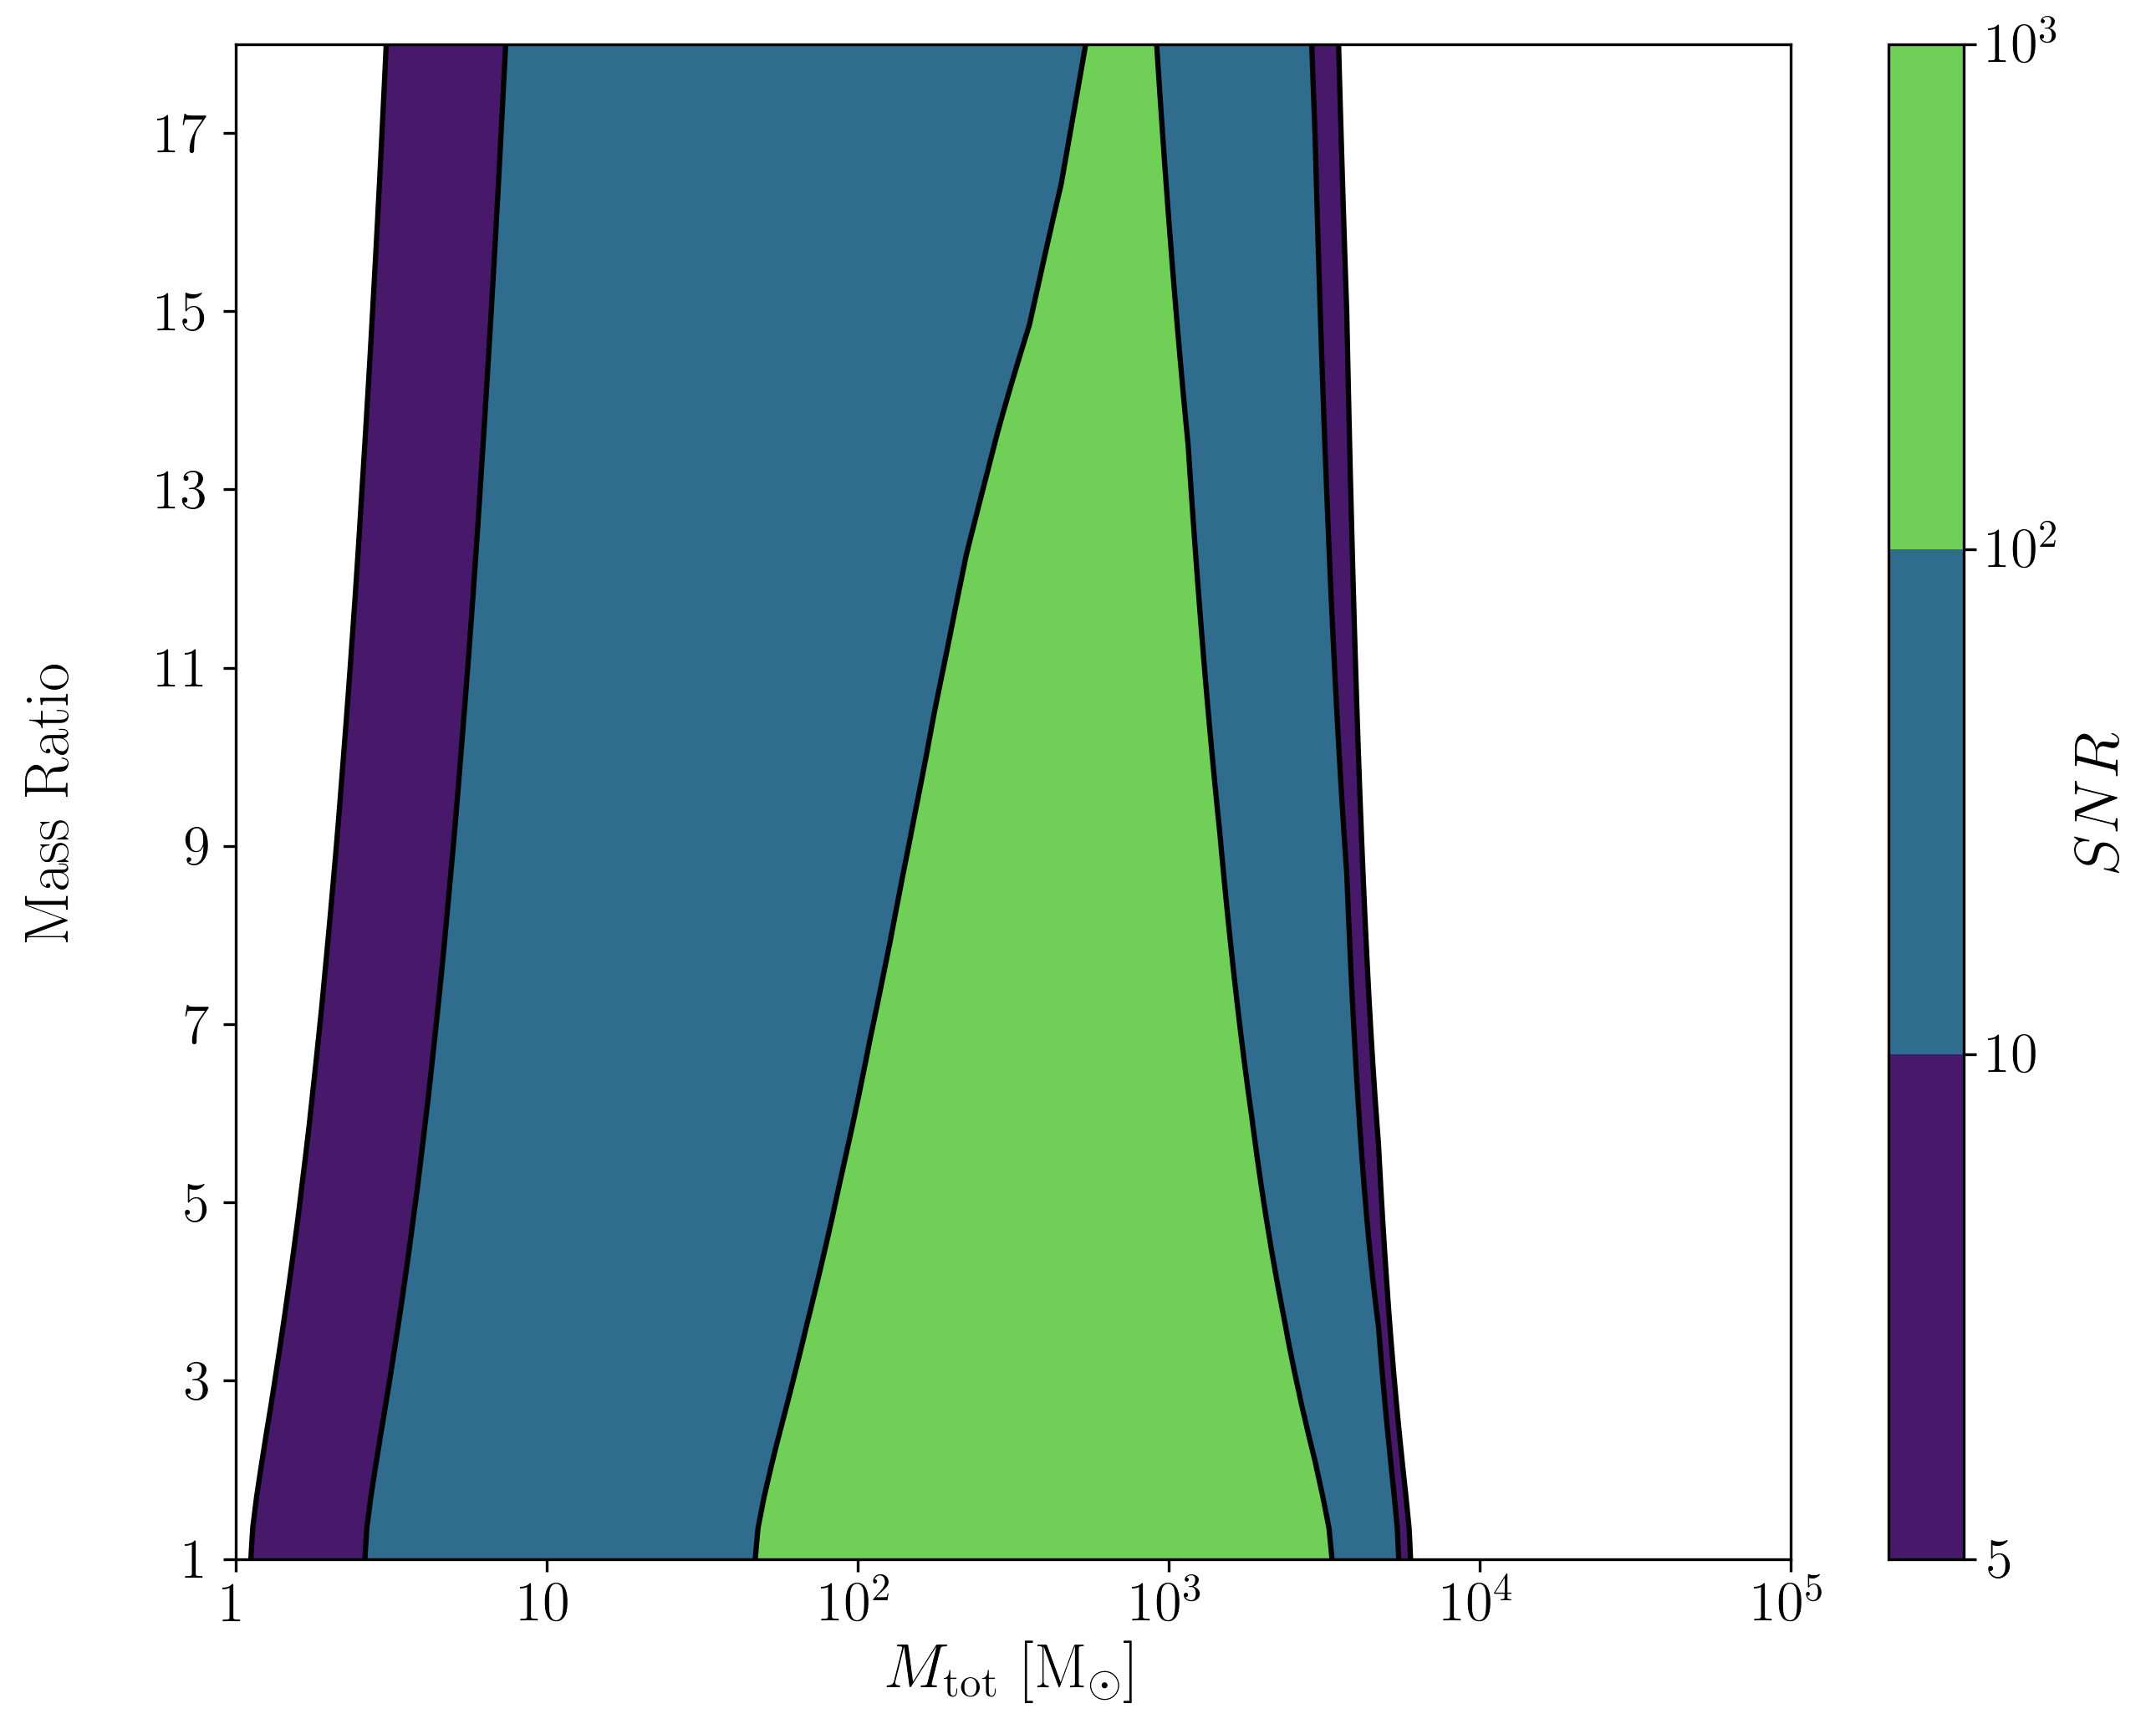

Model:  ET_M_vs_q ,  done. t = :  20.113433837890625
here


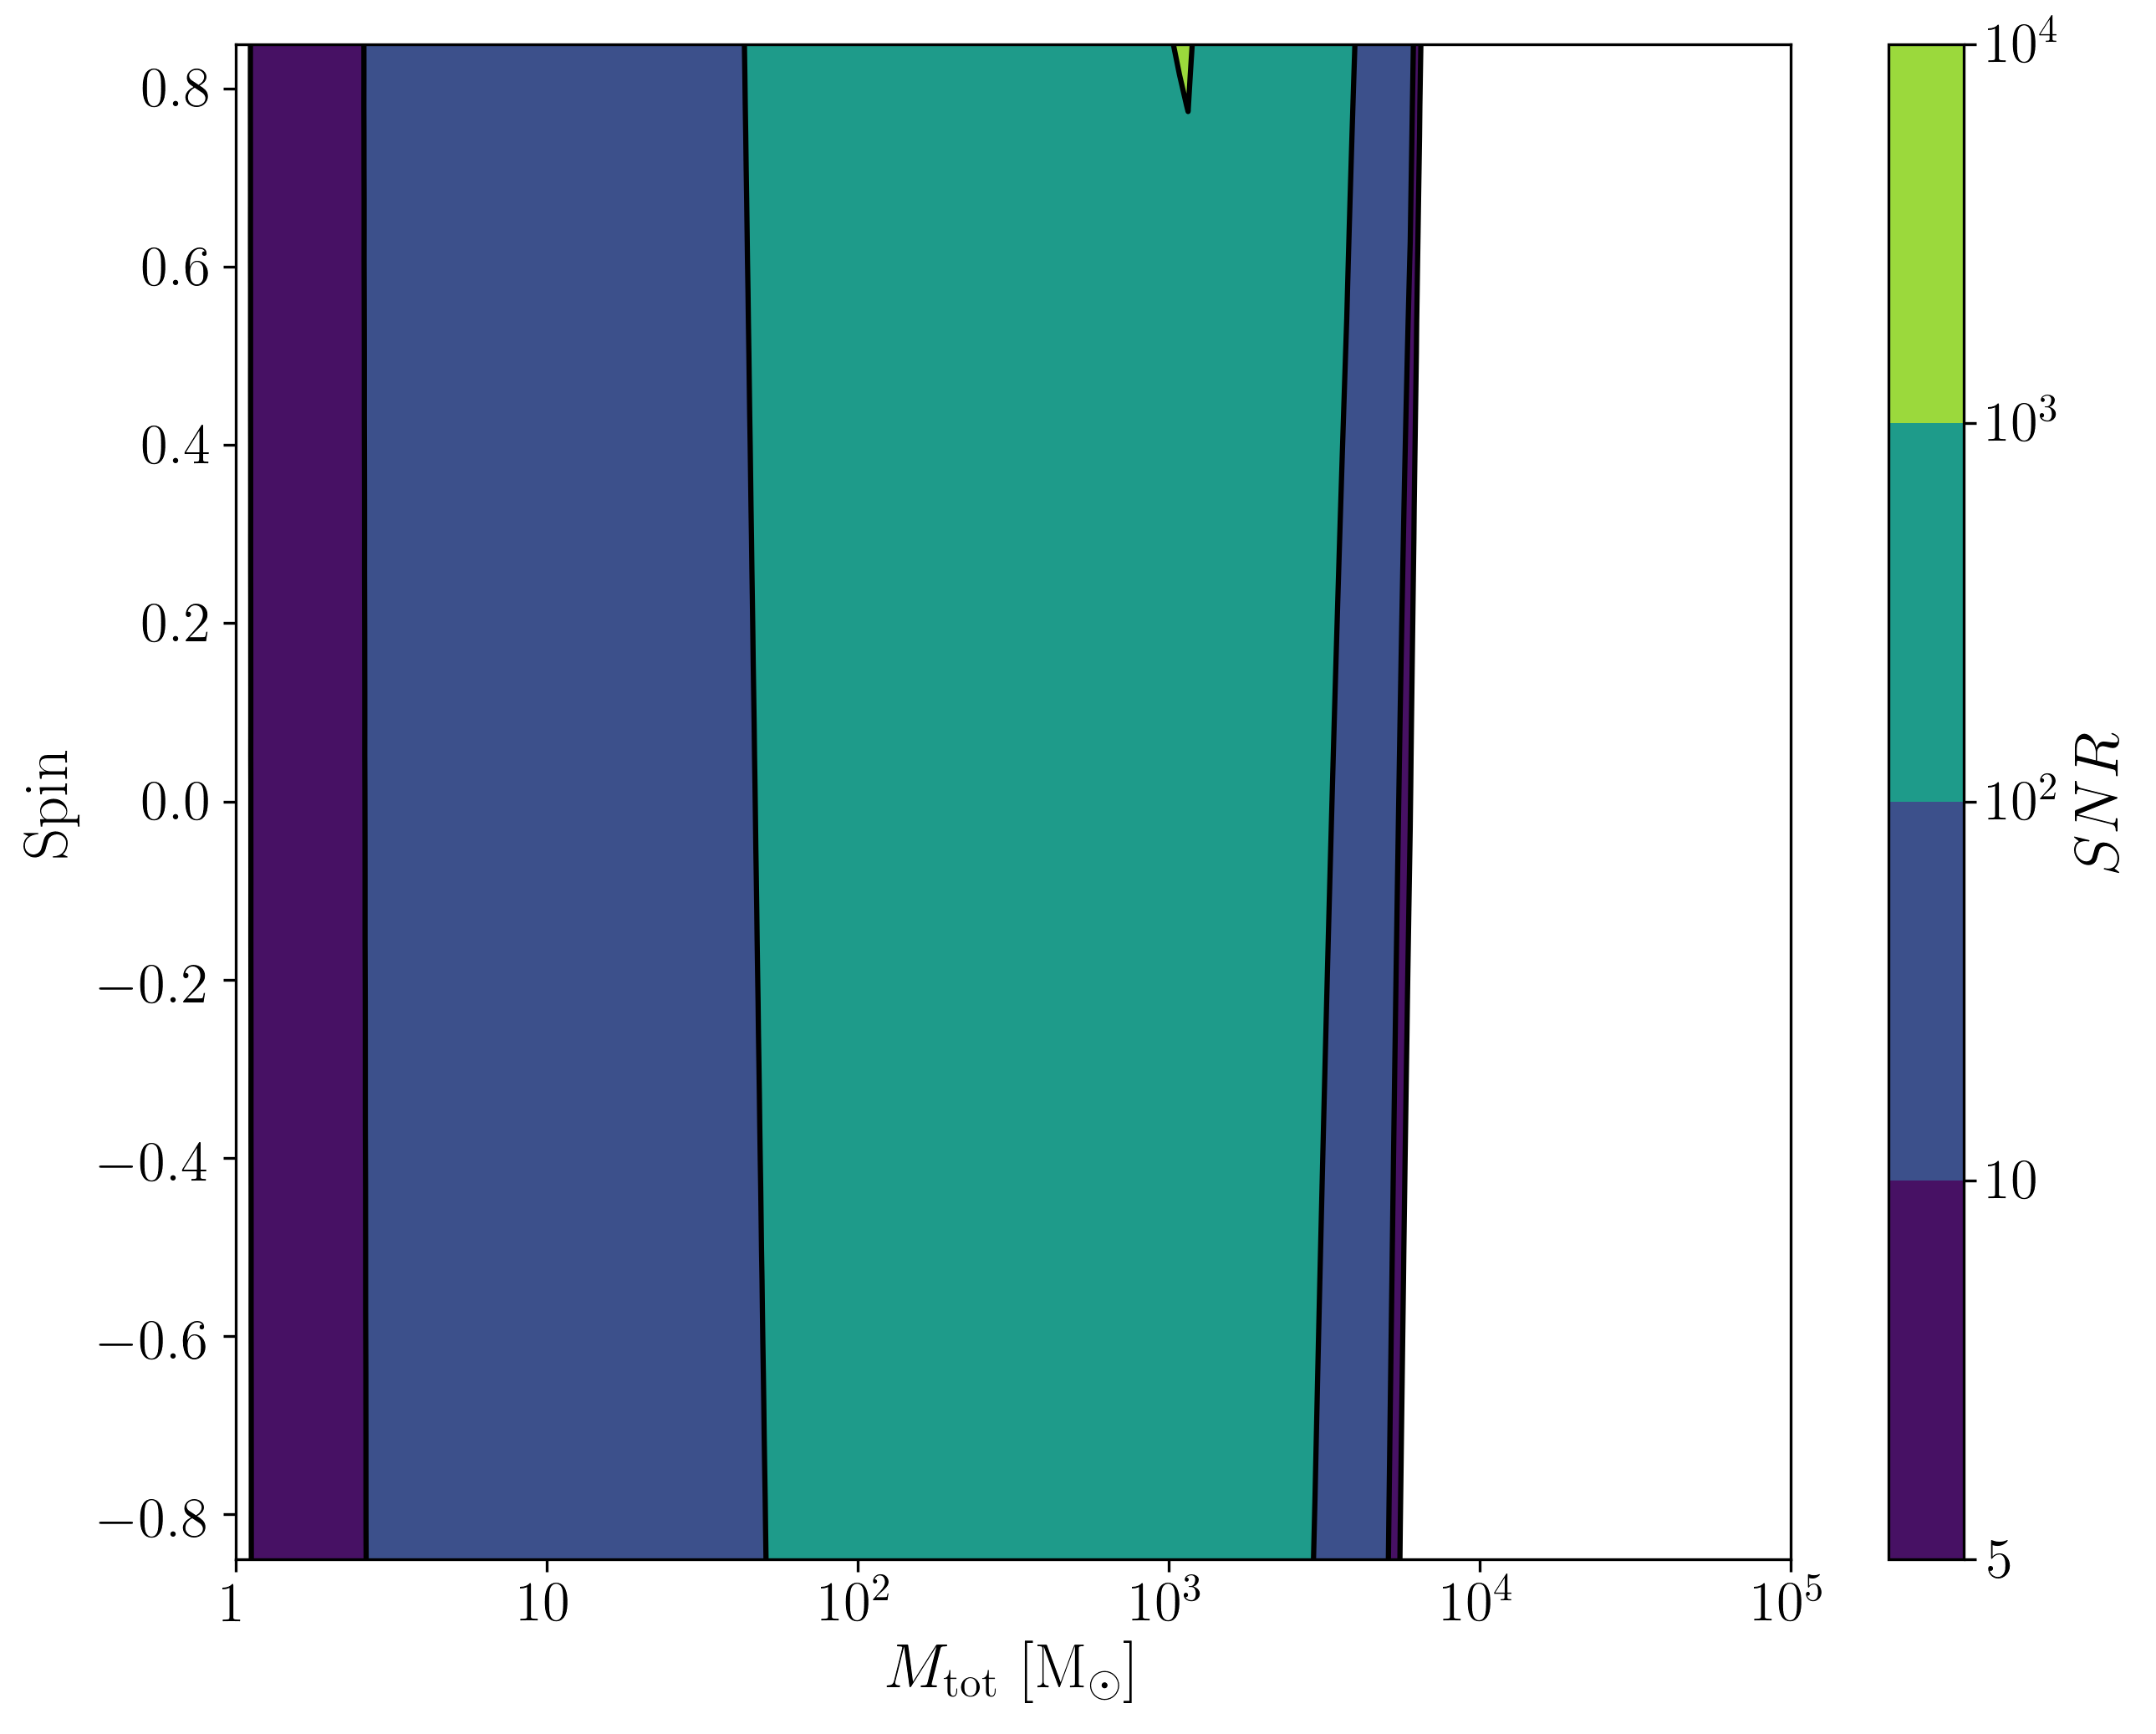

Model:  ET_M_vs_chi2 ,  done. t = :  19.889232873916626


In [11]:
model = 0
instrument = Get_Instrument(model)
for var_y in var_ys:
    source = Get_Source(model)
    start = time.time()
    [sample_x,sample_y,SNRMatrix] = snr.Get_SNR_Matrix(source,instrument,
                                                       var_x,sampleRate_x,
                                                       var_y,sampleRate_y)
    end = time.time()
    snrplot.Plot_SNR(source,instrument,var_x,sample_x,var_y,sample_y,SNRMatrix,
                     dl_axis=False,smooth_contours=False)

    print('Model: ',instrument.name + '_' + var_x + '_vs_' + var_y,',',' done. t = : ',end-start)

#### aLIGO

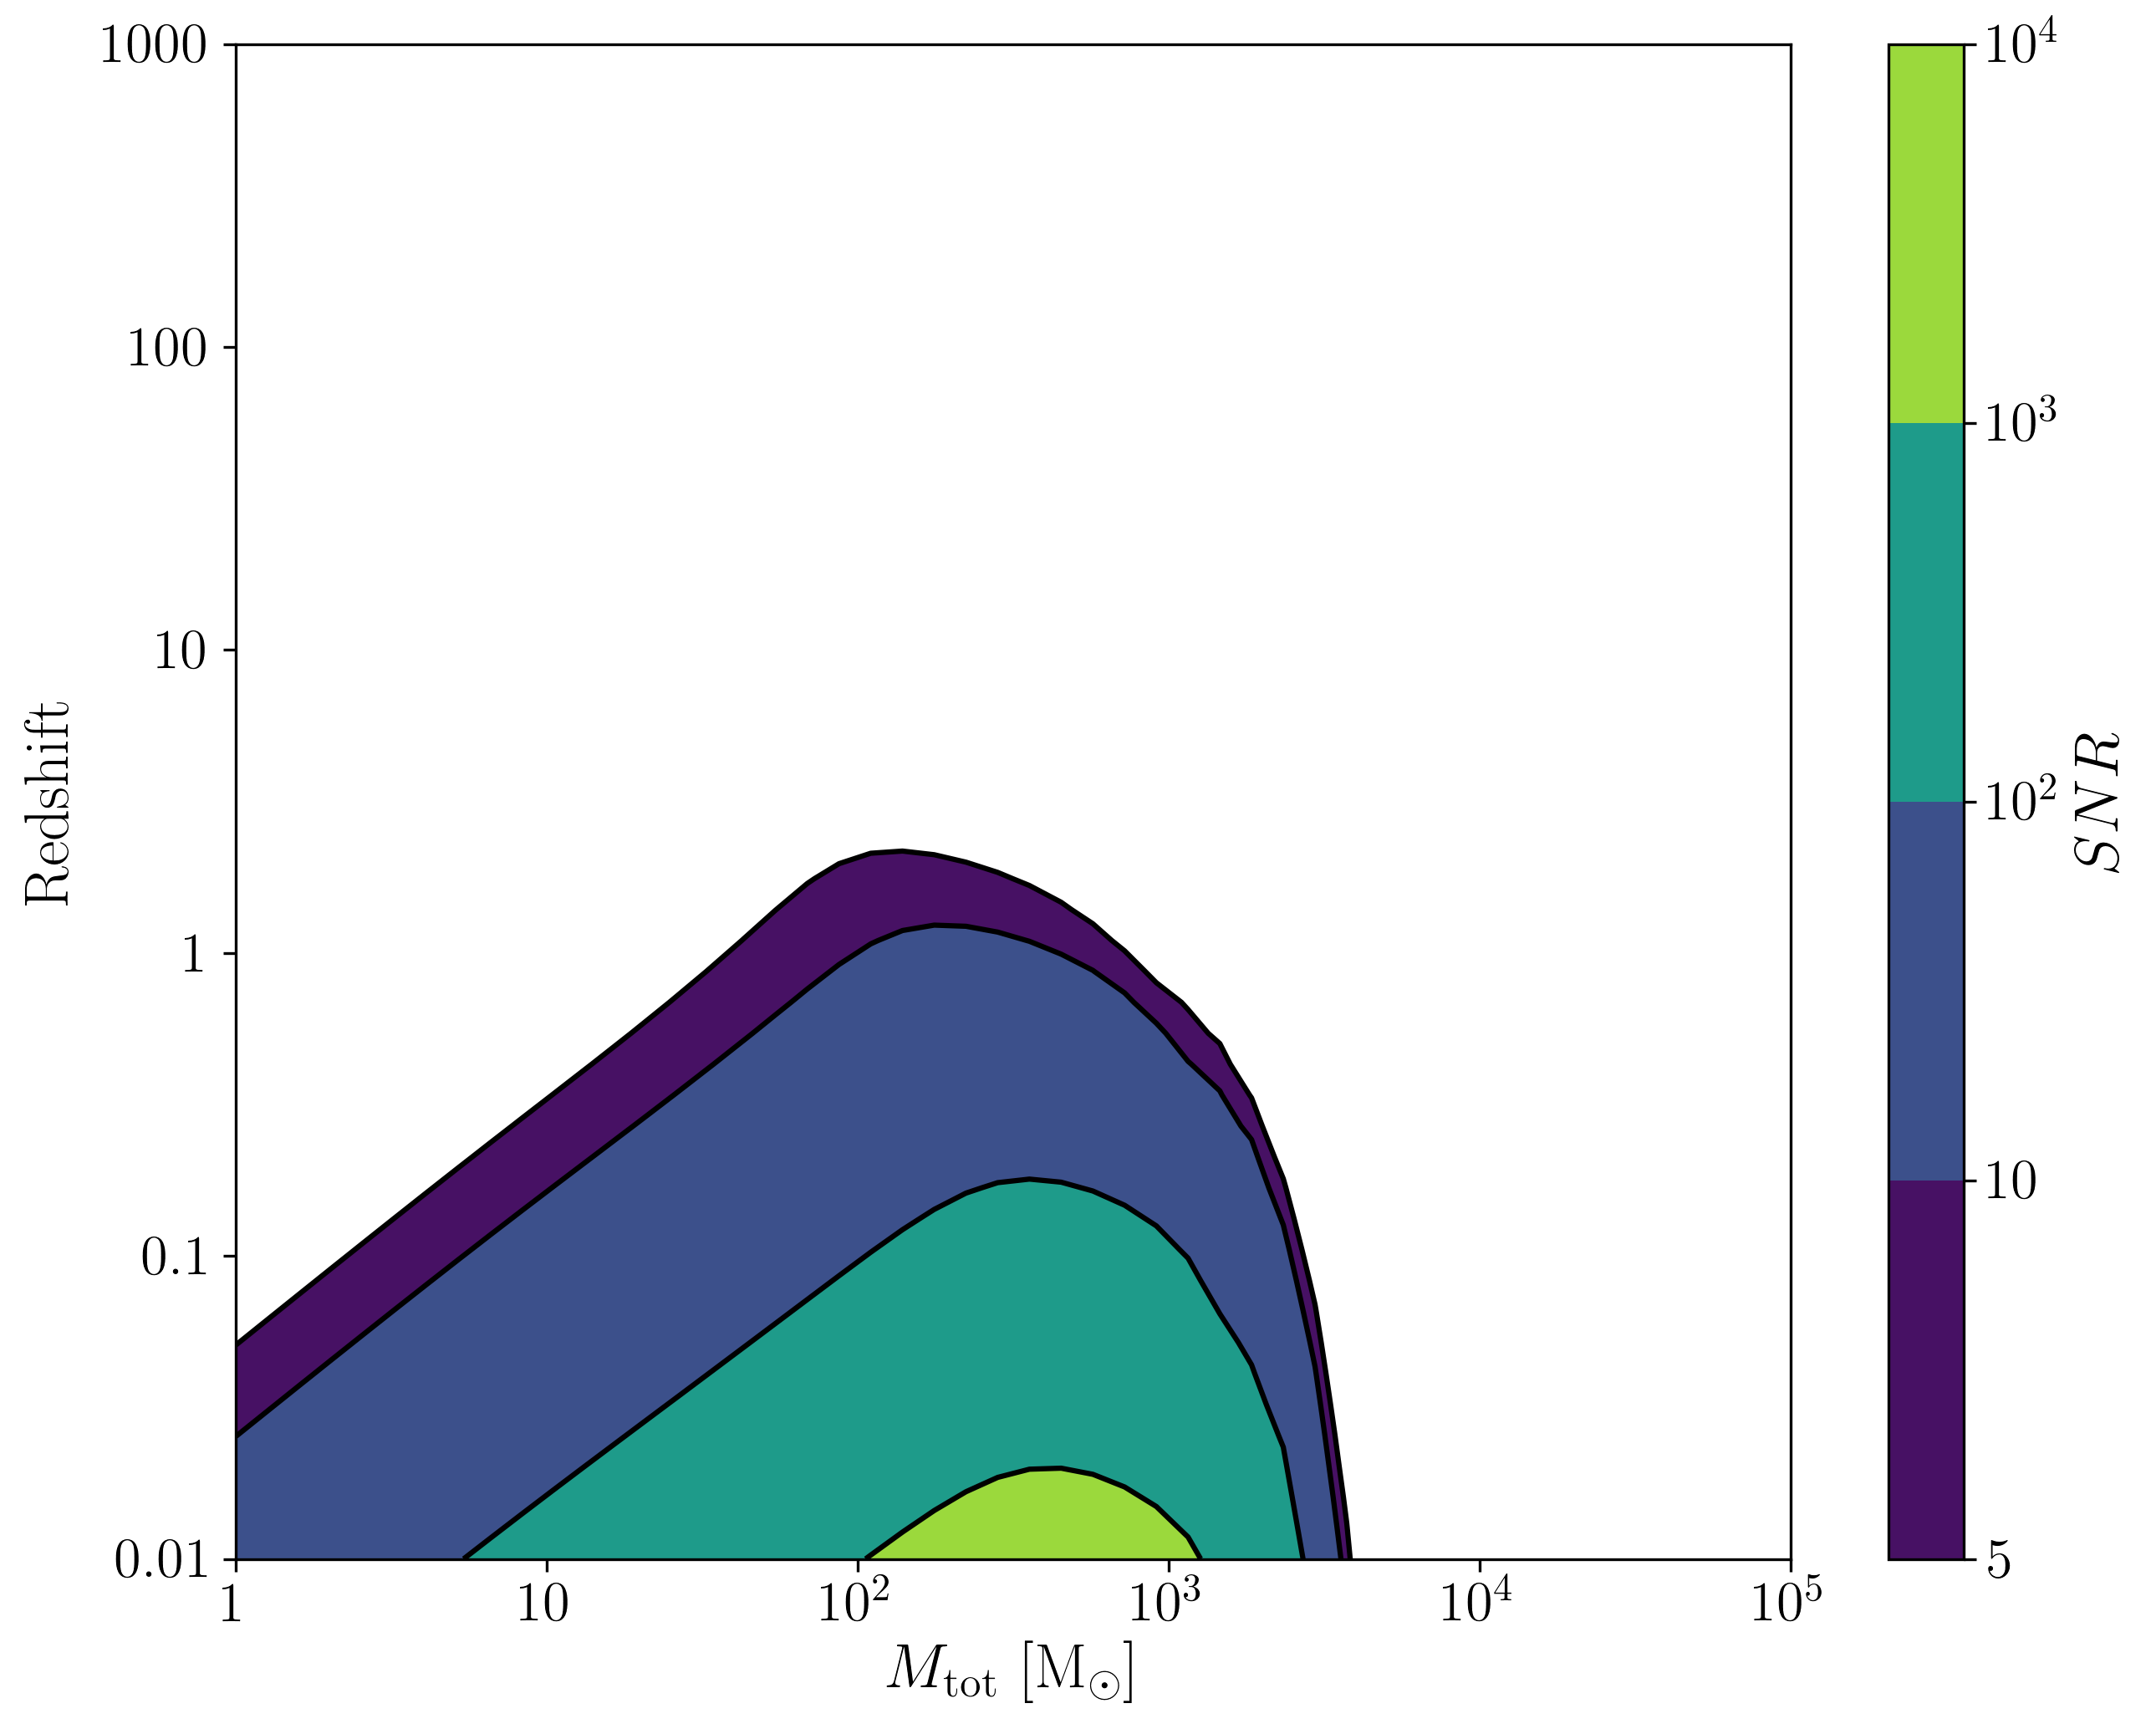

Model:  aLIGO_M_vs_z ,  done. t = :  17.014657974243164


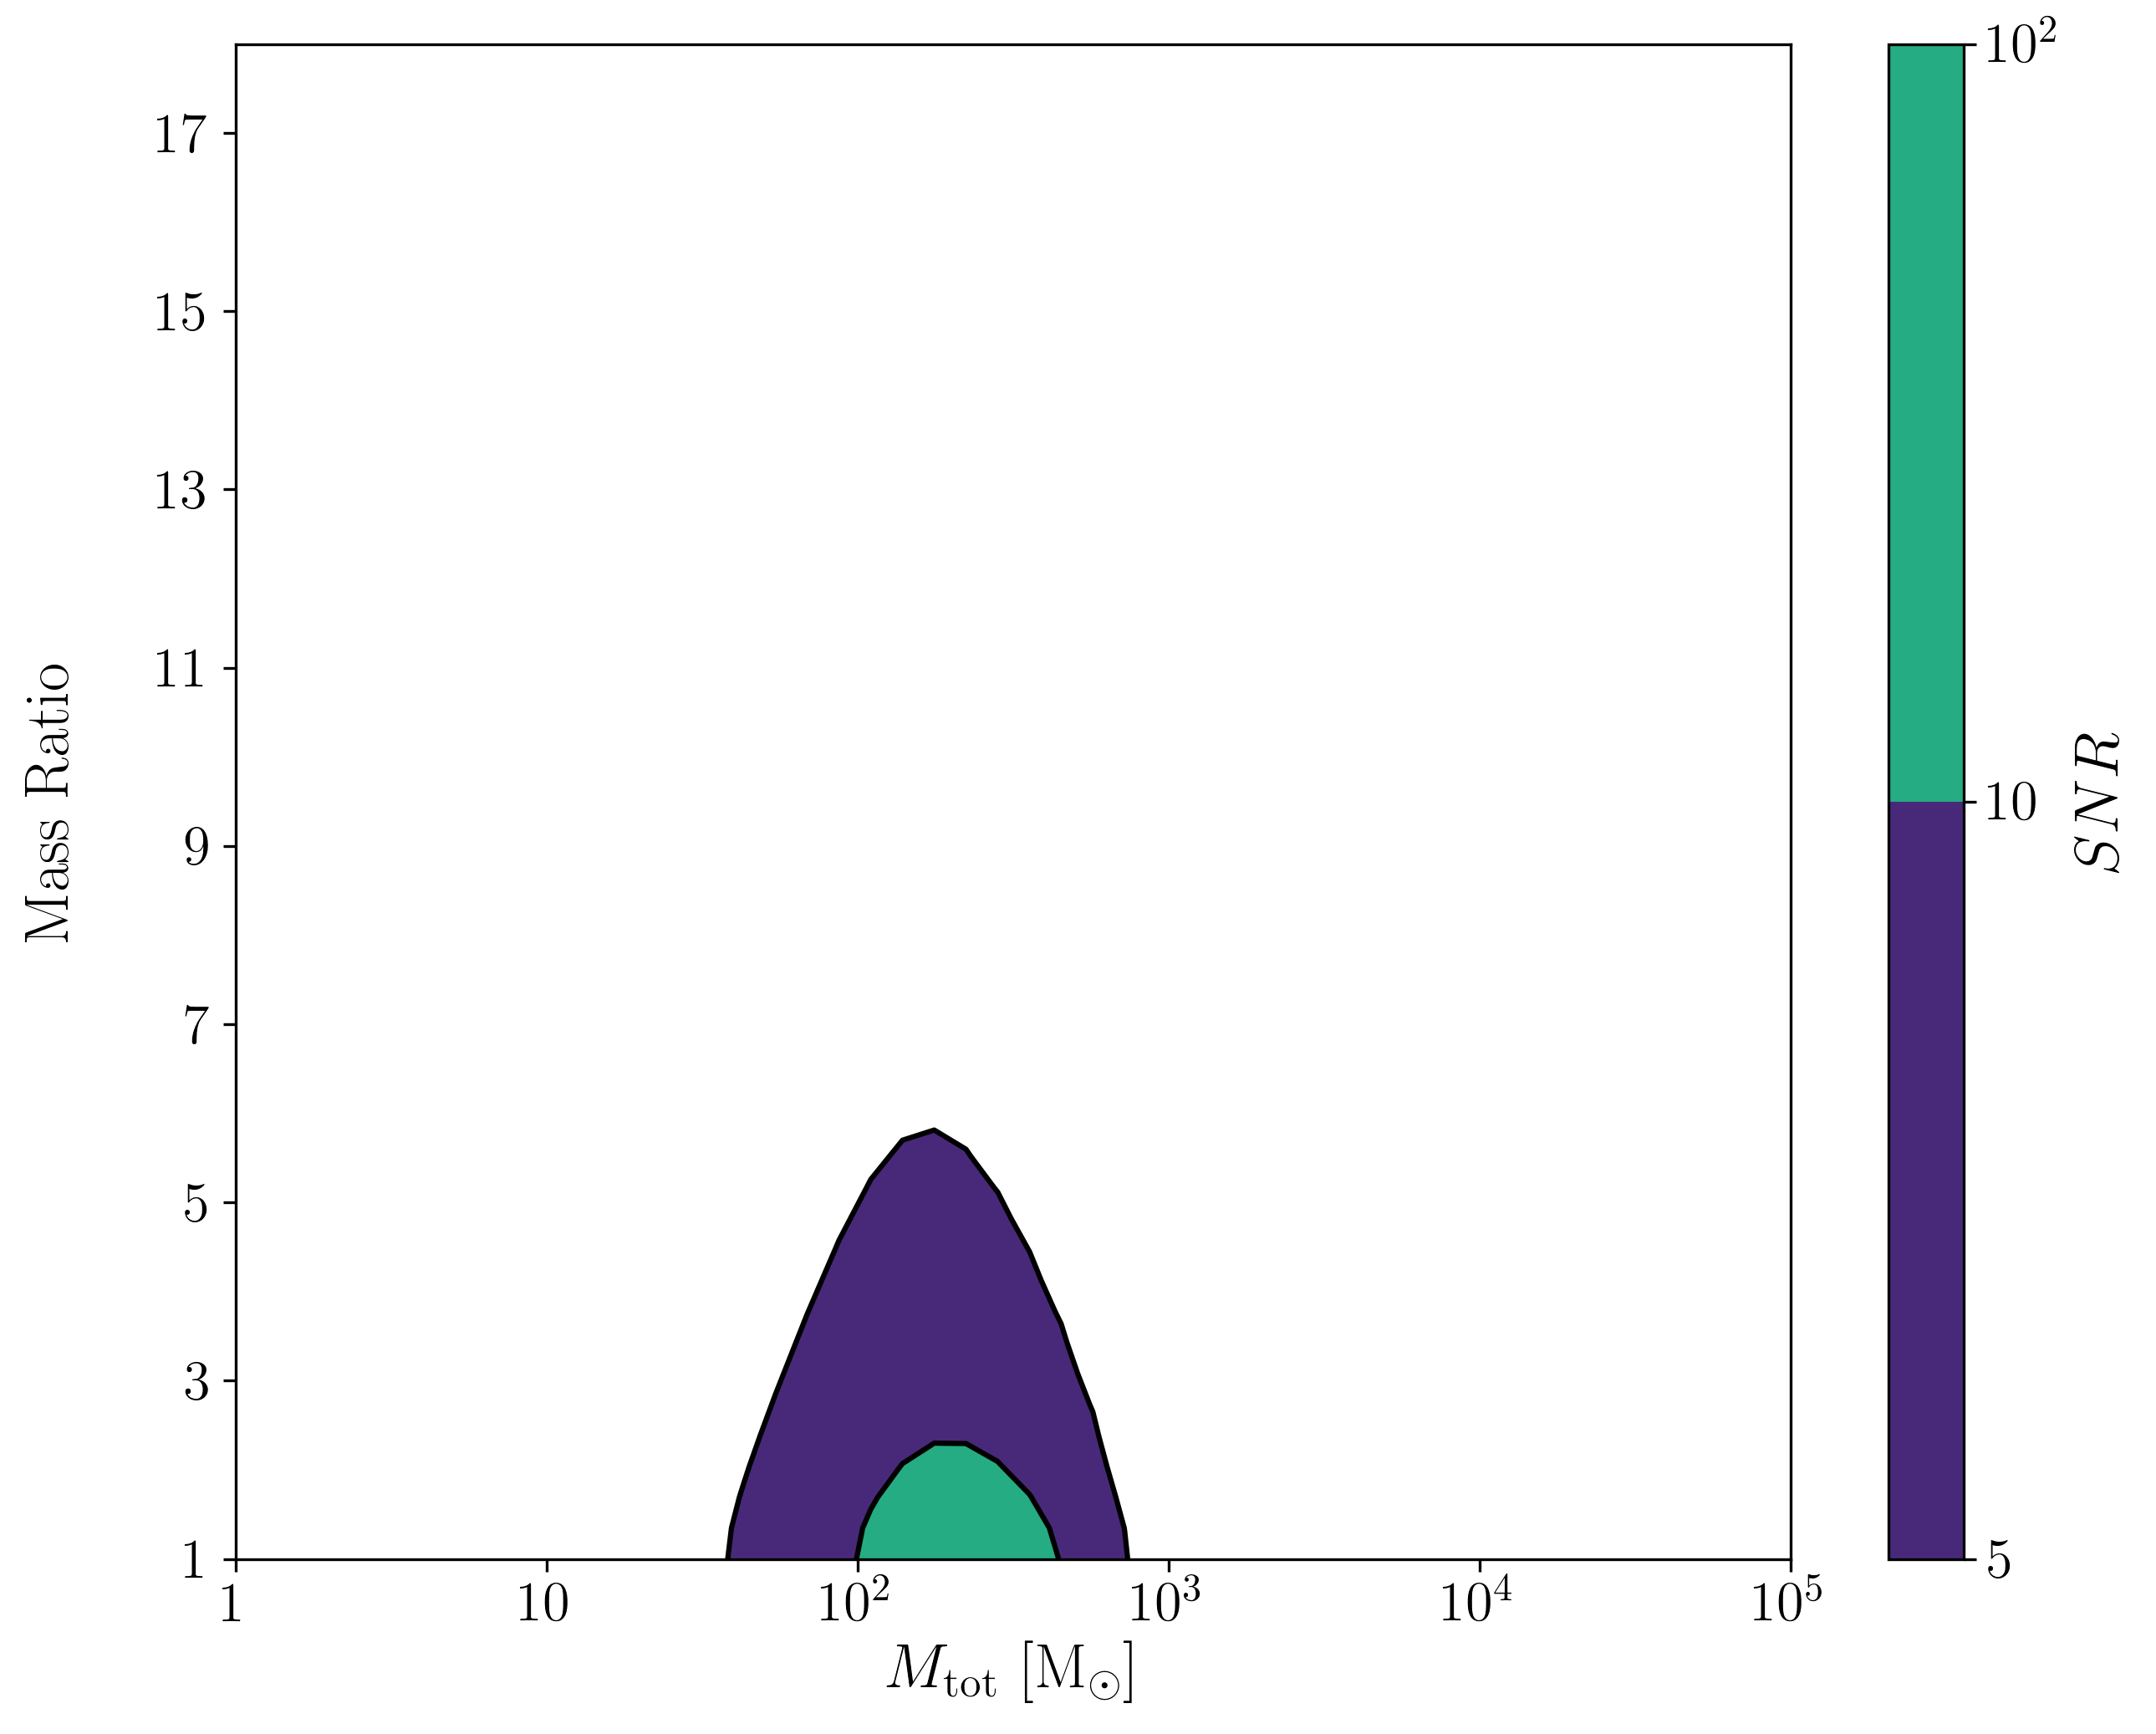

Model:  aLIGO_M_vs_q ,  done. t = :  20.479567766189575
here


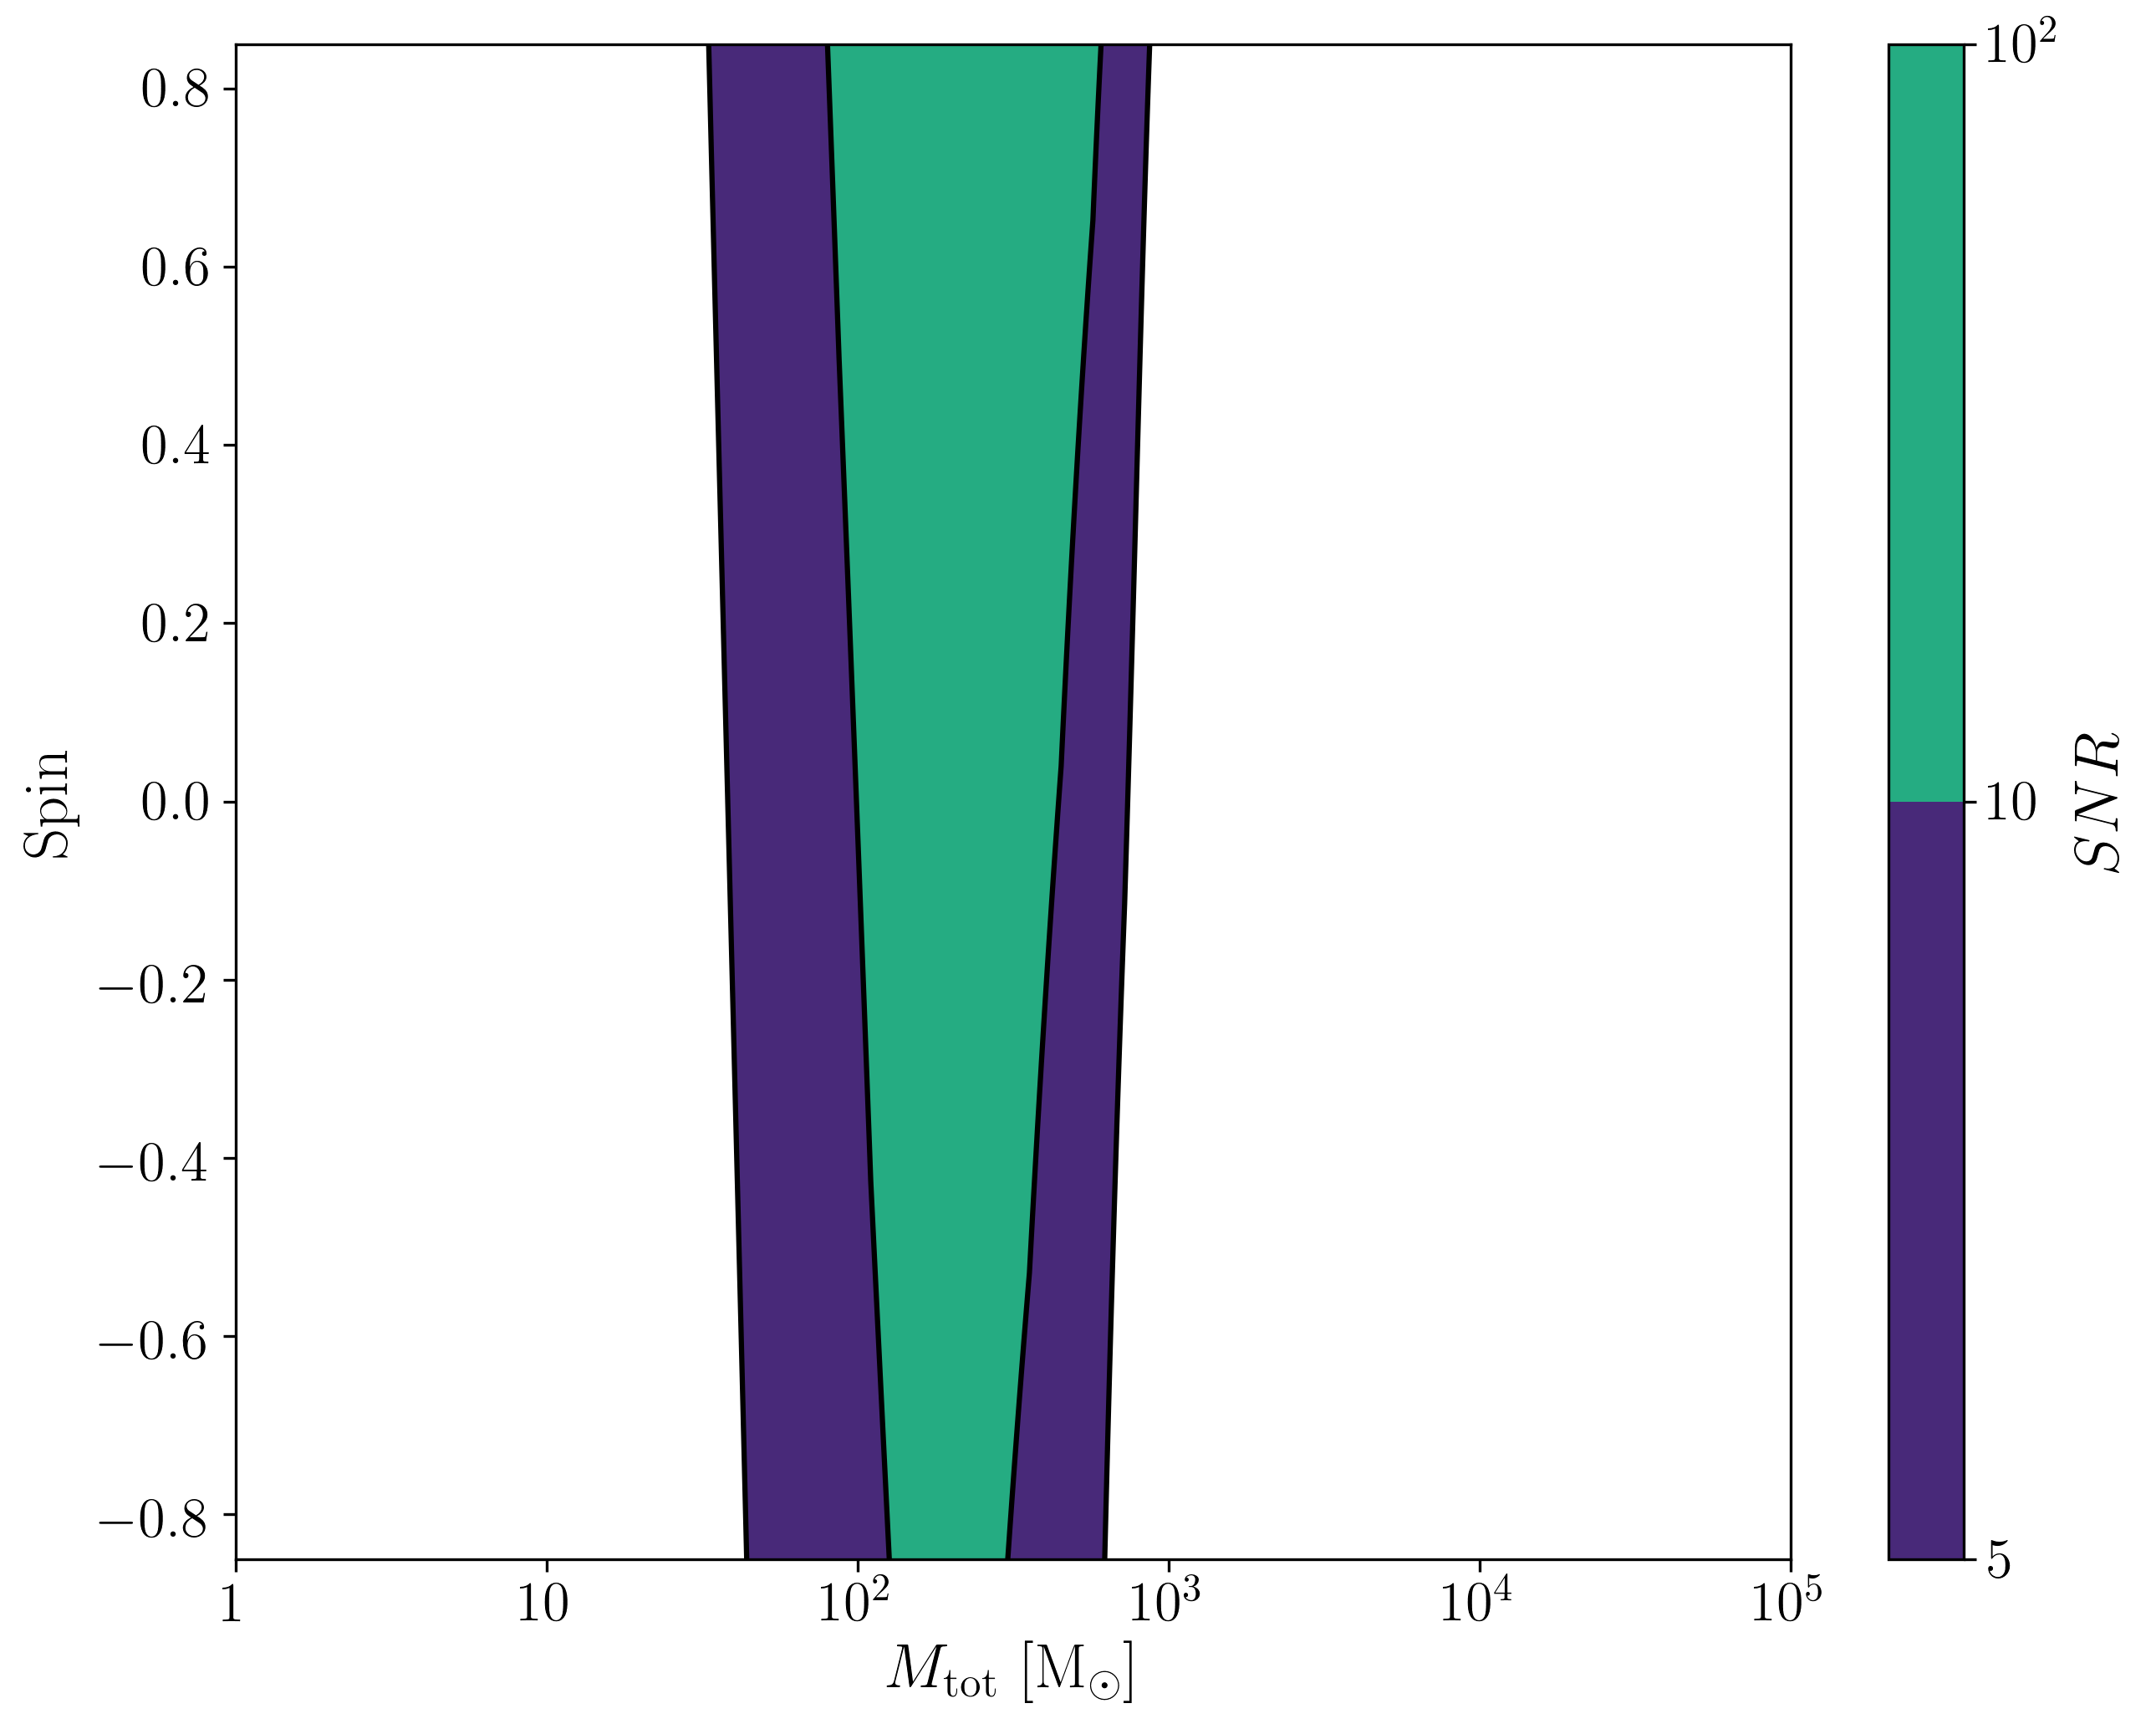

Model:  aLIGO_M_vs_chi2 ,  done. t = :  19.58860492706299


In [12]:
model = 1
instrument = Get_Instrument(model)
for var_y in var_ys:
    source = Get_Source(model)
    start = time.time()
    [sample_x,sample_y,SNRMatrix] = snr.Get_SNR_Matrix(source,instrument,
                                                       var_x,sampleRate_x,
                                                       var_y,sampleRate_y)
    end = time.time()
    snrplot.Plot_SNR(source,instrument,var_x,sample_x,var_y,sample_y,SNRMatrix,
                     dl_axis=False,smooth_contours=False)

    print('Model: ',instrument.name + '_' + var_x + '_vs_' + var_y,',',' done. t = : ',end-start)

### PTAs

These can take a really long time if you vary the instrument parameters. Be careful with your sample rates!

#### NANOGrav WN only

In [13]:
#Number of SNRMatrix rows
sampleRate_y = 10
#Number of SNRMatrix columns
sampleRate_x = 10
#Variable on y-axis
var_y = 'cadence'
#Variable on x-axis
var_x = 'M'

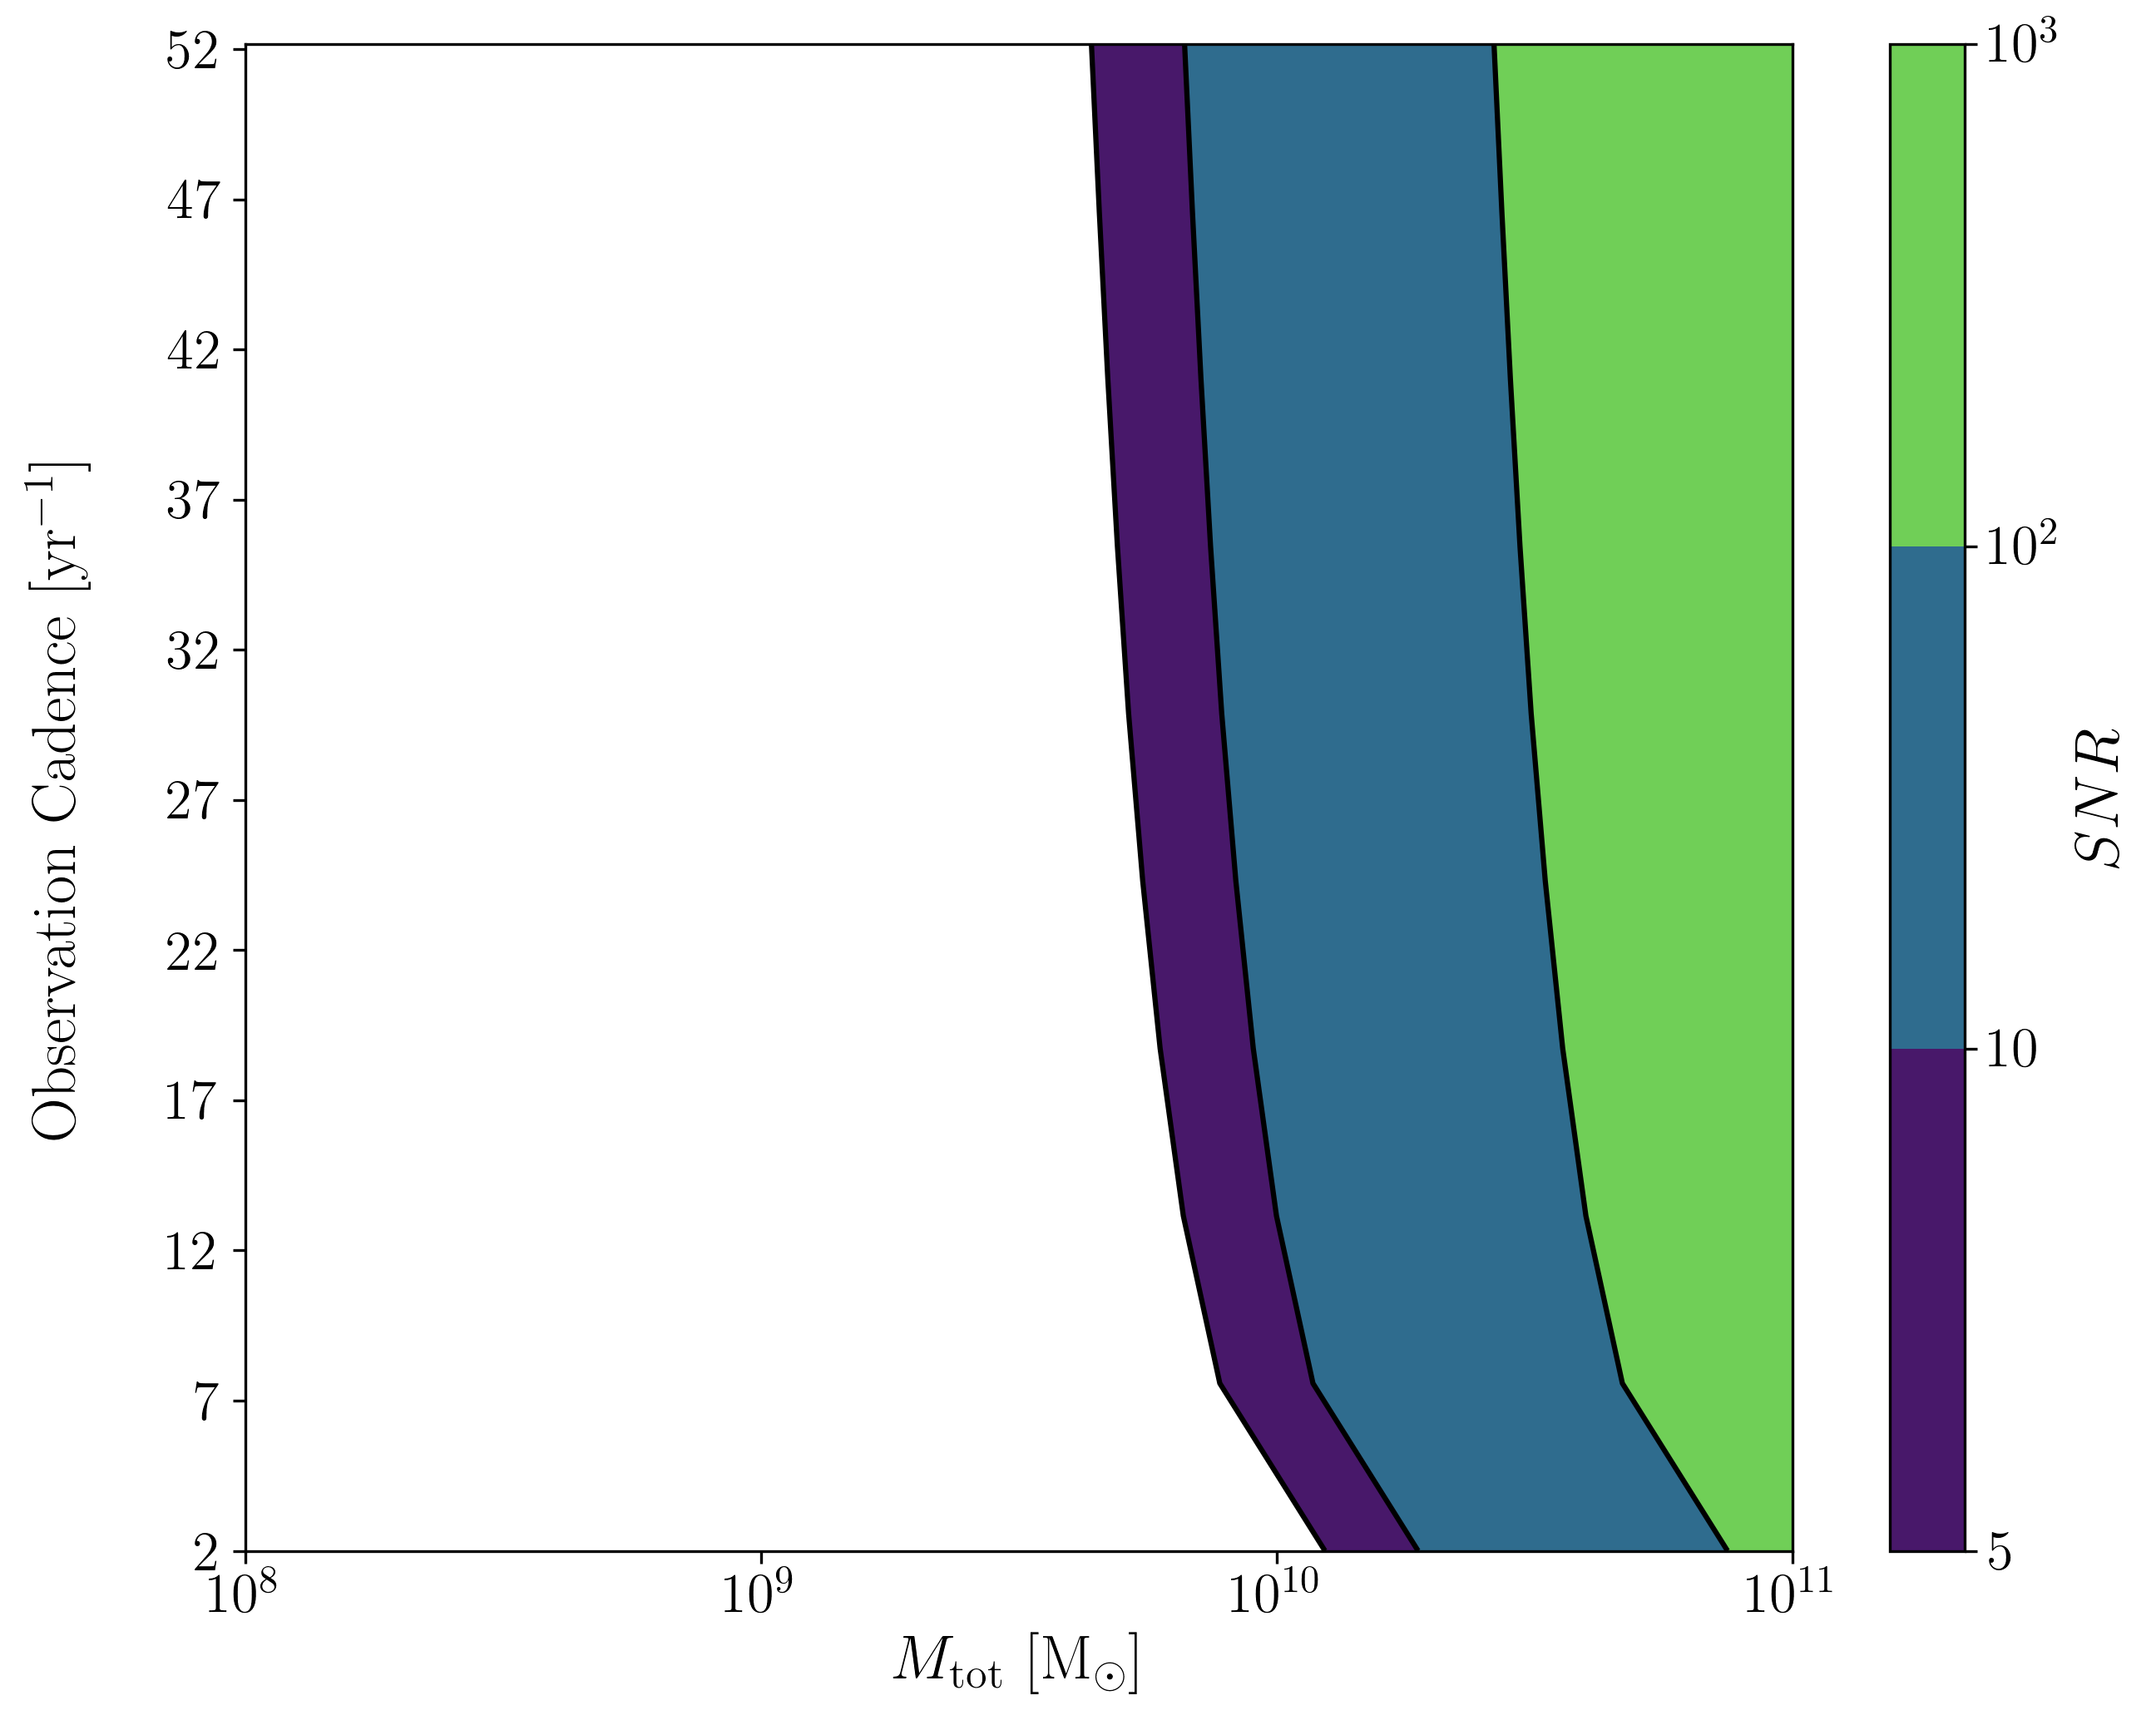

Model:  NANOGrav_WN_M_vs_cadence ,  done. t = :  44.62179899215698


In [14]:
model = 2
instrument = Get_Instrument(model)
source = Get_Source(model)
start = time.time()
[sample_x,sample_y,SNRMatrix] = snr.Get_SNR_Matrix(source,instrument,
                                                   var_x,sampleRate_x,
                                                   var_y,sampleRate_y)
end = time.time()
snrplot.Plot_SNR(source,instrument,var_x,sample_x,var_y,sample_y,SNRMatrix,
                 dl_axis=False,smooth_contours=False)

print('Model: ',instrument.name + '_' + var_x + '_vs_' + var_y,',',' done. t = : ',end-start)

#### NANOGrav Realistic Noise

In [15]:
#Variable on y-axis
var_y = 'N_p'
#Variable on x-axis
var_x = 'M'

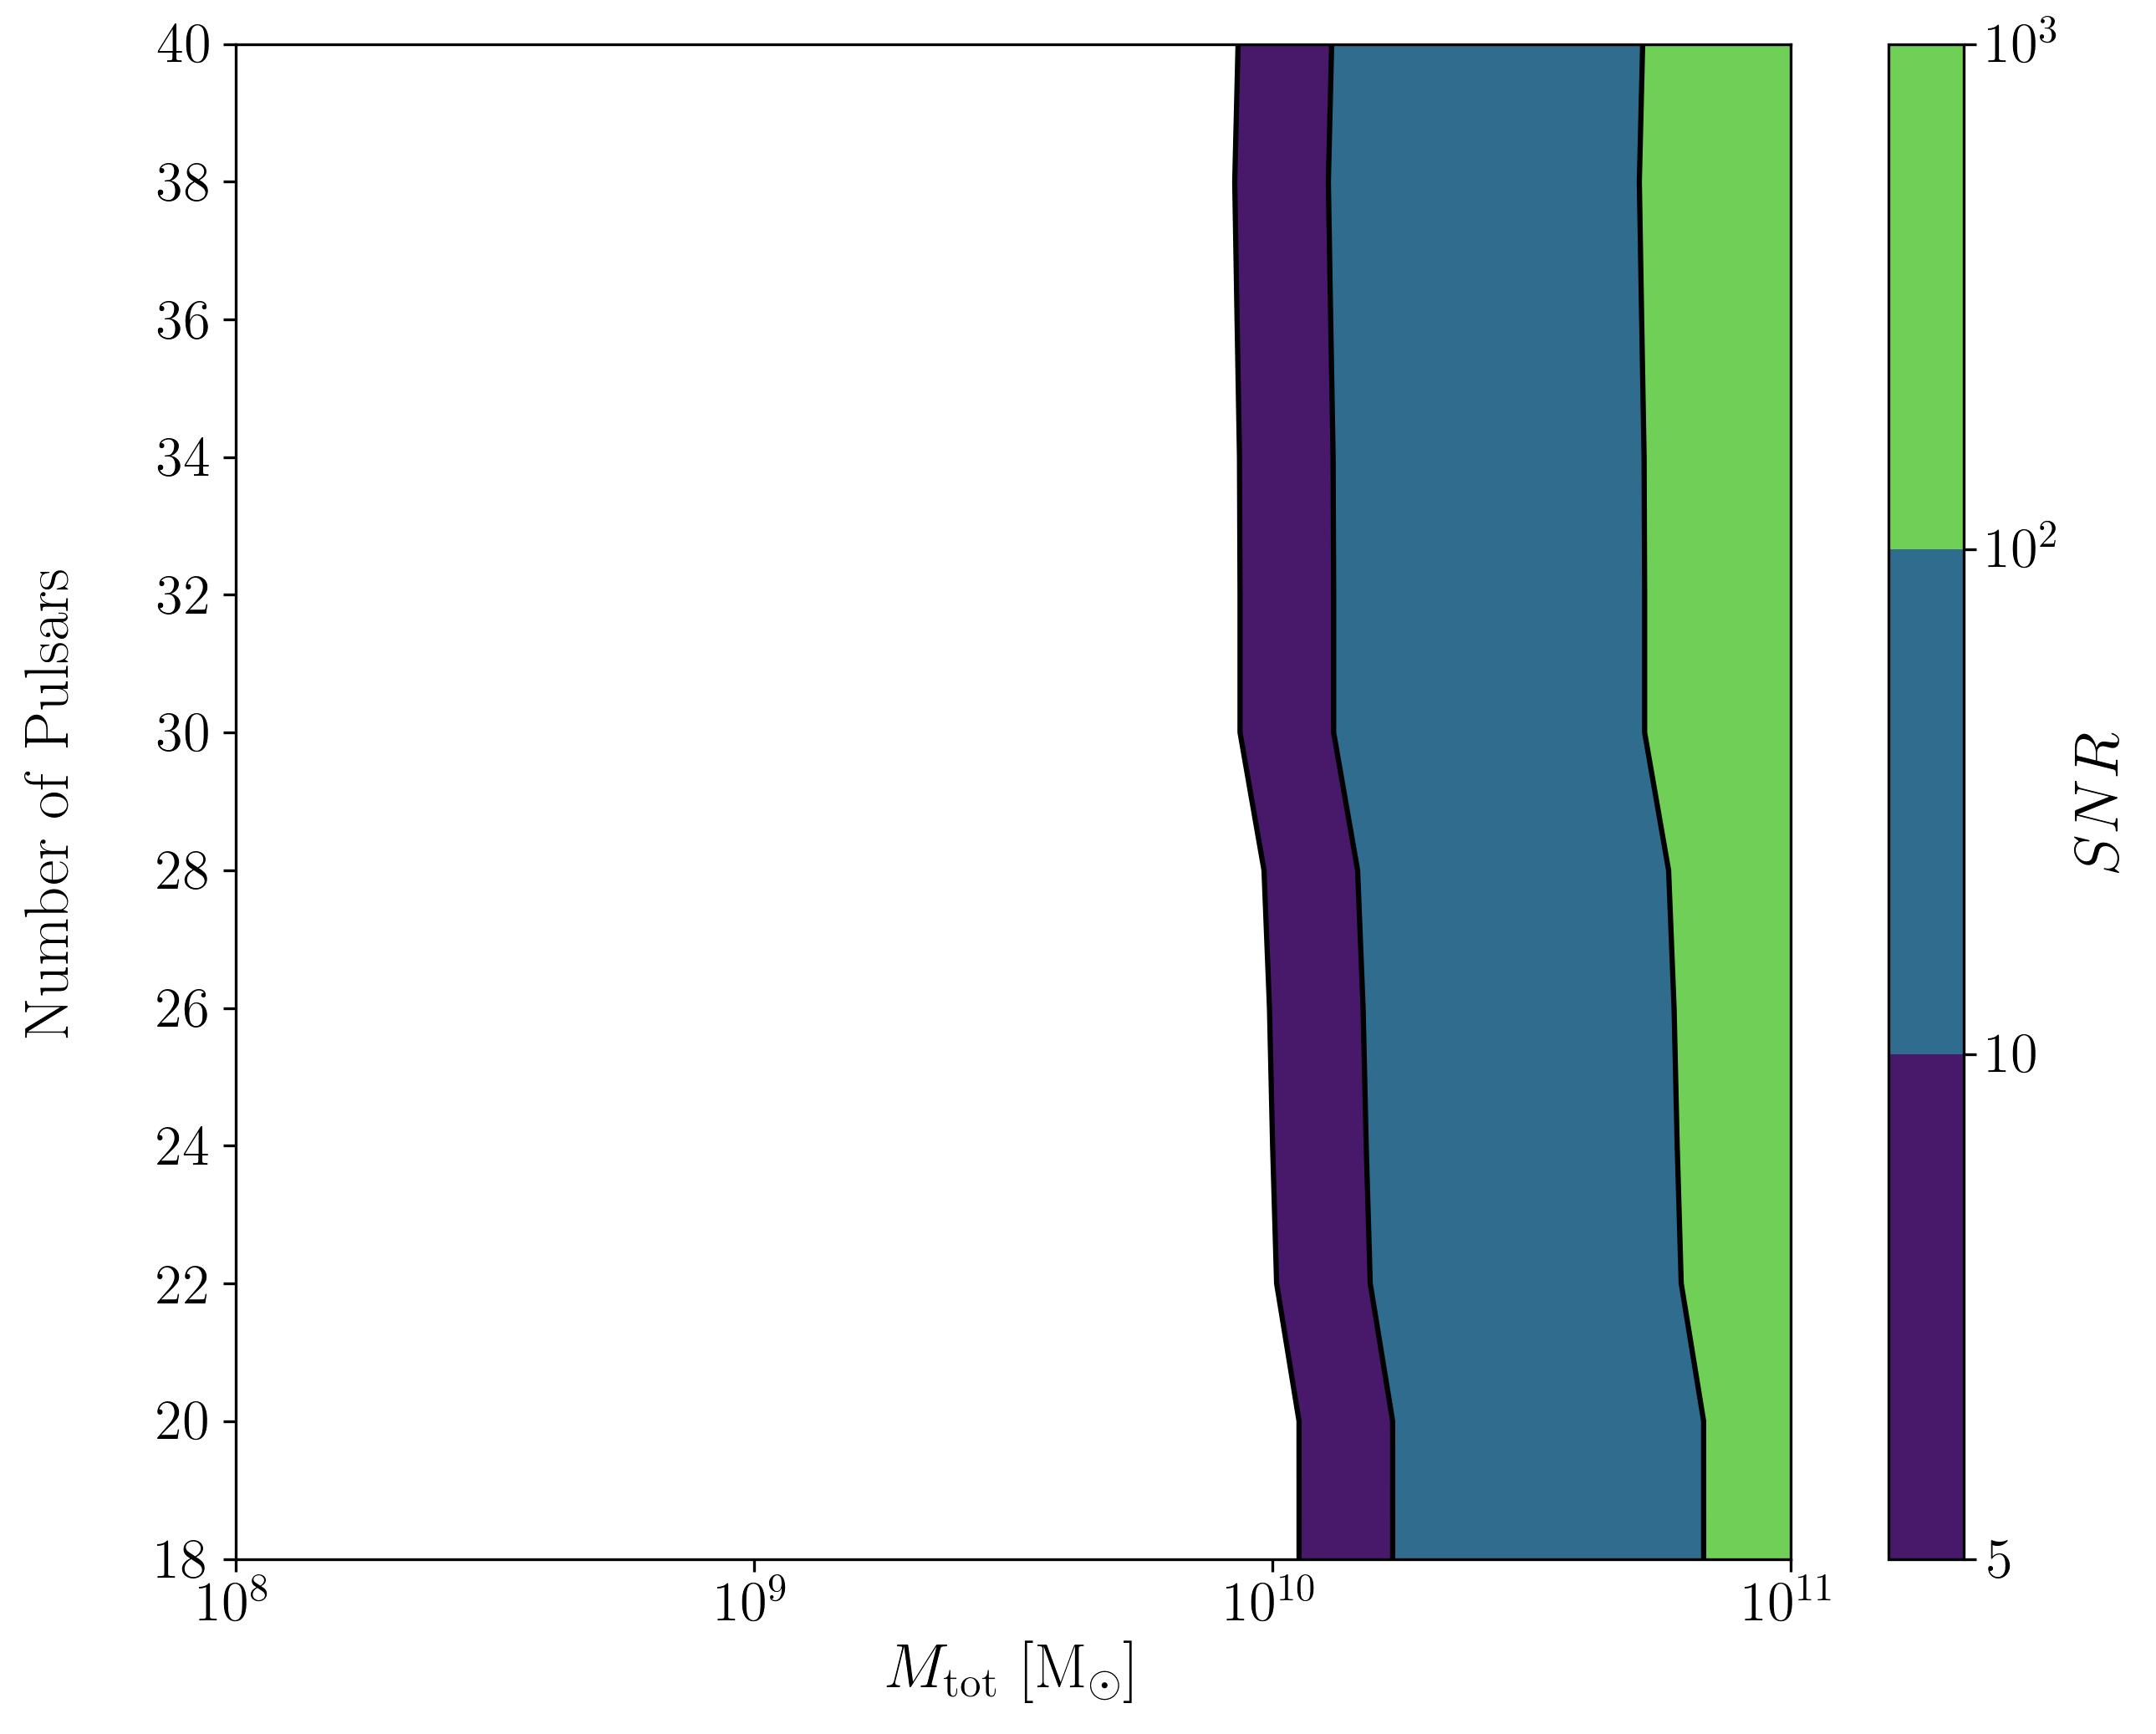

Model:  NANOGrav_realistic_noise_M_vs_N_p ,  done. t = :  88.37940716743469


In [16]:
model = 3
instrument = Get_Instrument(model)
source = Get_Source(model)
start = time.time()
[sample_x,sample_y,SNRMatrix] = snr.Get_SNR_Matrix(source,instrument,
                                                   var_x,sampleRate_x,
                                                   var_y,sampleRate_y)
end = time.time()
snrplot.Plot_SNR(source,instrument,var_x,sample_x,var_y,sample_y,SNRMatrix,
                 dl_axis=False,smooth_contours=False)

print('Model: ',instrument.name + '_' + var_x + '_vs_' + var_y,',',' done. t = : ',end-start)

#### NANOGrav 11yr Data

In [17]:
#Number of SNRMatrix rows
sampleRate_y = 50
#Number of SNRMatrix columns
sampleRate_x = 50
#Variable on y-axis
var_y = 'q'
#Variable on x-axis
var_x = 'M'

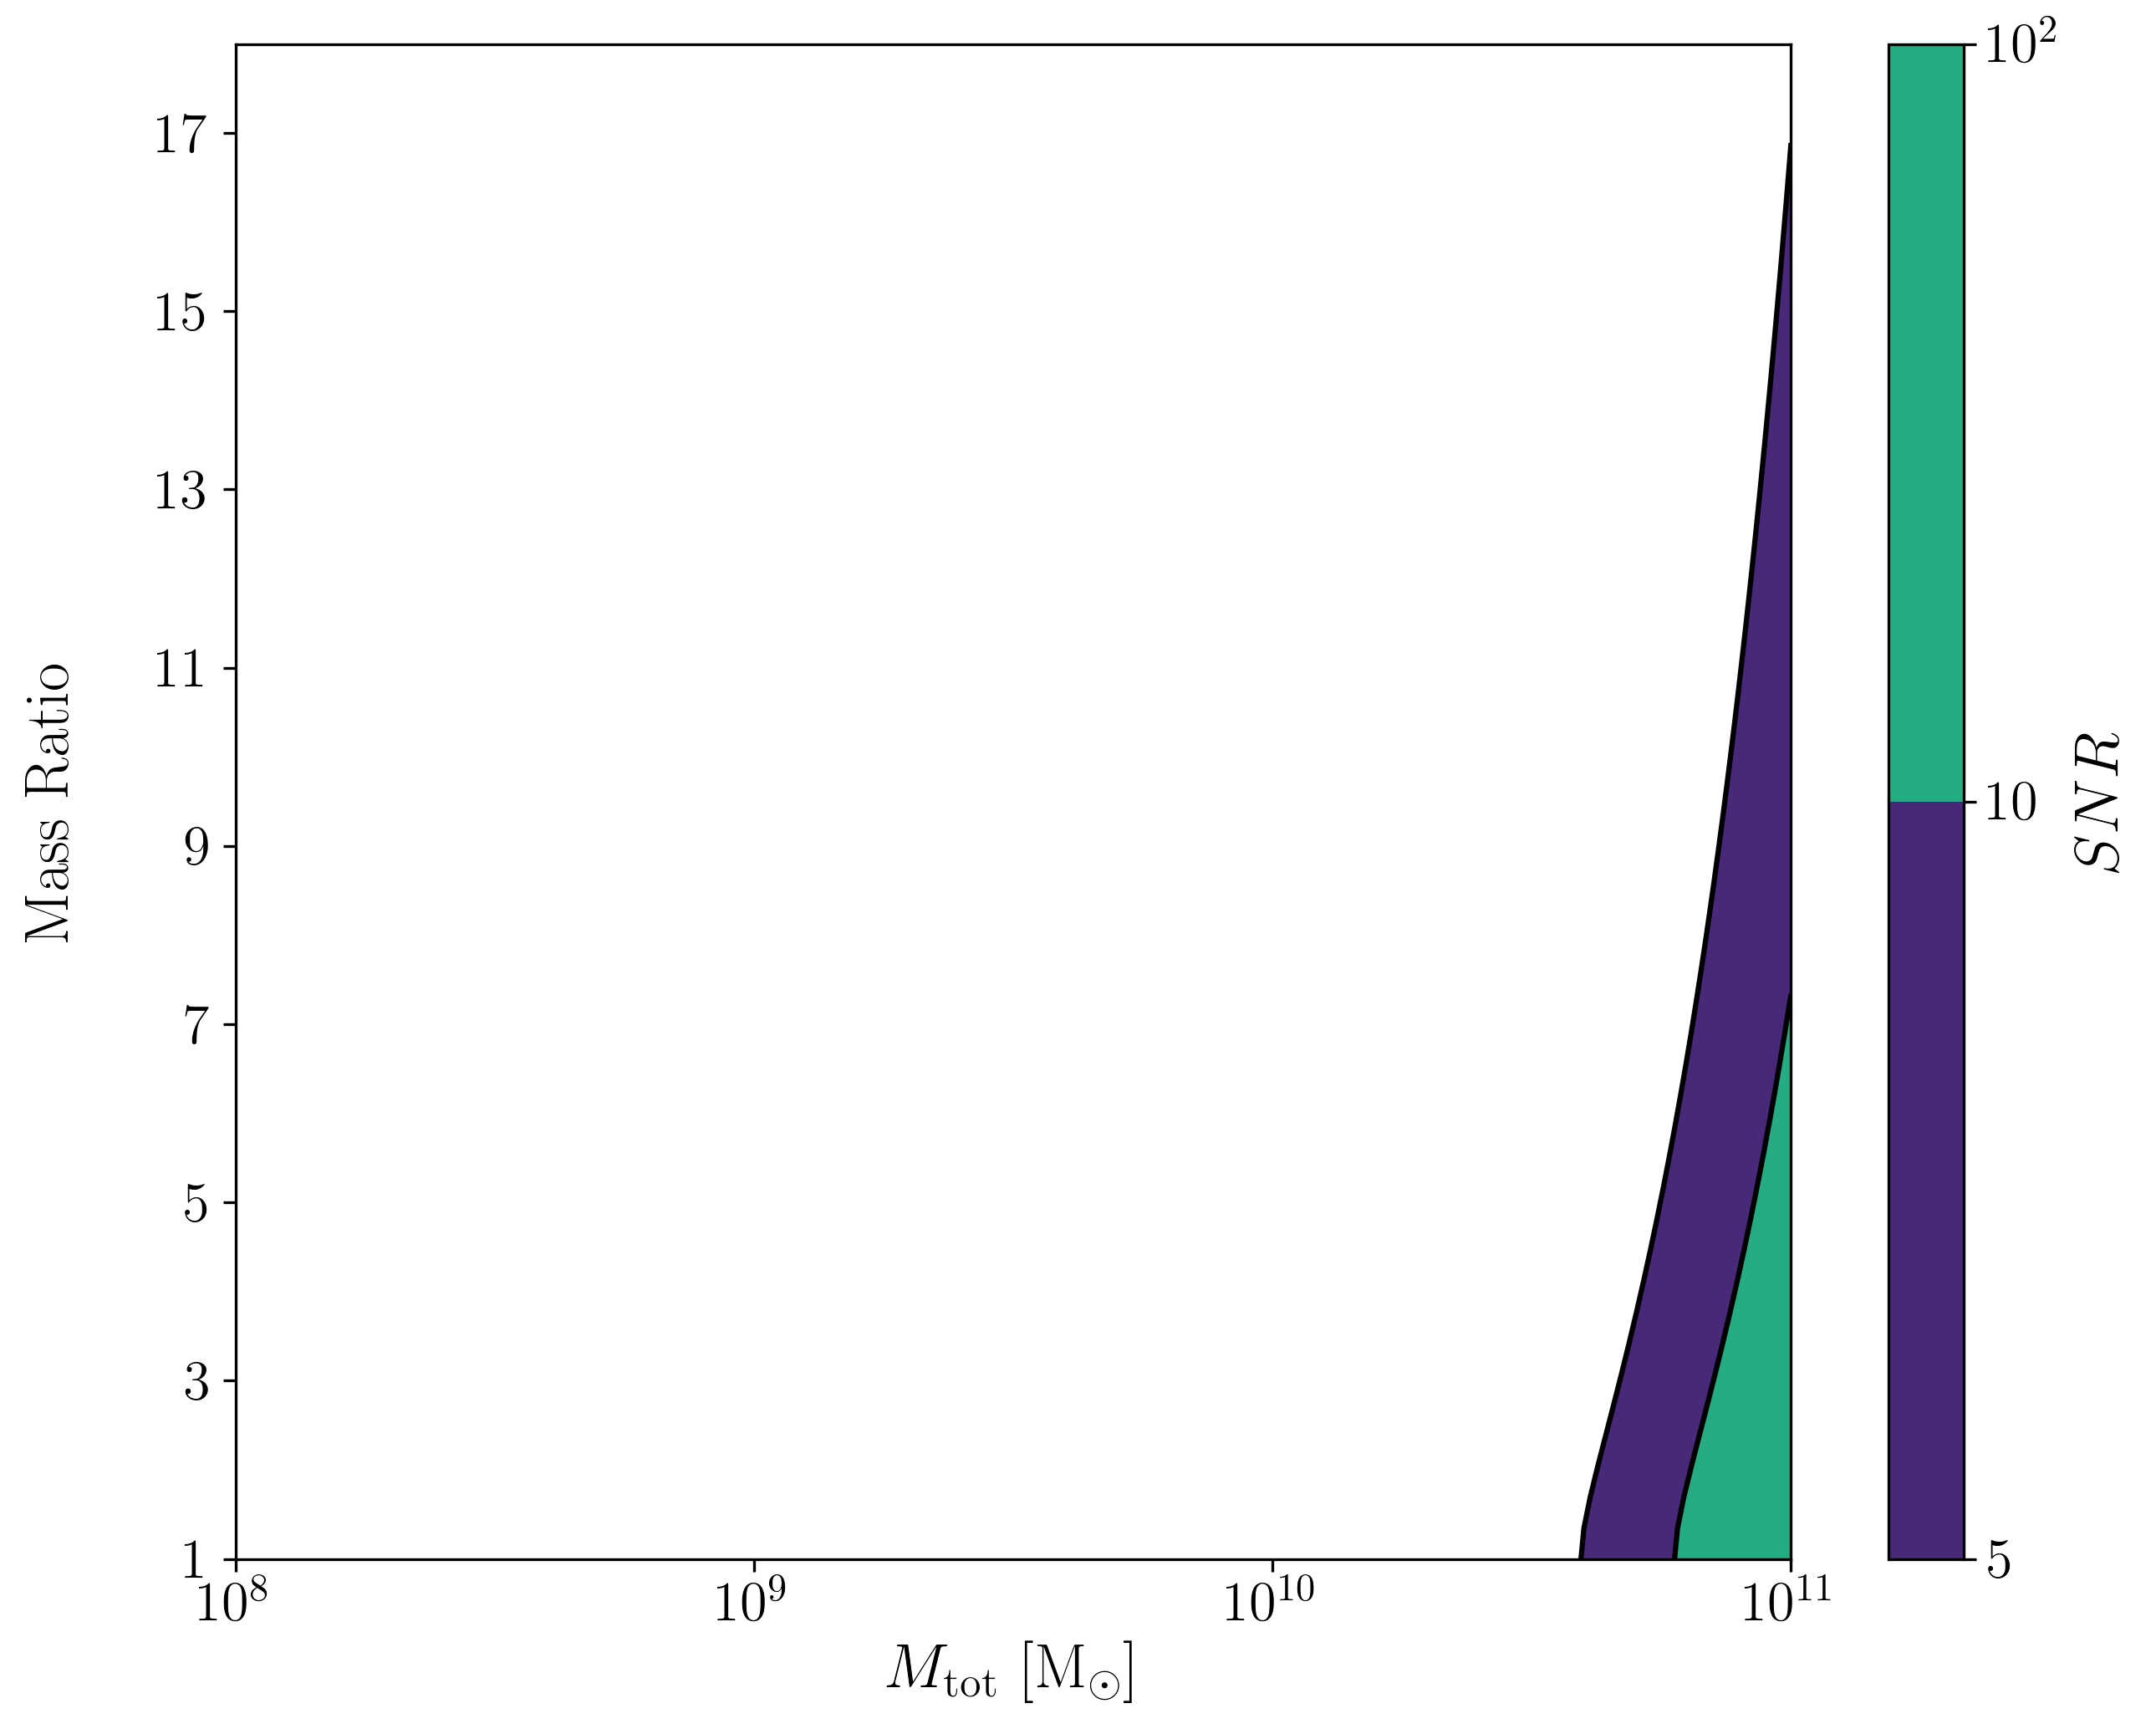

Model:  NANOGrav_11yr_M_vs_q ,  done. t = :  11.418483972549438


In [18]:
model = 4
instrument = Get_Instrument(model)
source = Get_Source(model)
start = time.time()
[sample_x,sample_y,SNRMatrix] = snr.Get_SNR_Matrix(source,instrument,
                                                   var_x,sampleRate_x,
                                                   var_y,sampleRate_y)
end = time.time()
snrplot.Plot_SNR(source,instrument,var_x,sample_x,var_y,sample_y,SNRMatrix,
                 dl_axis=False,smooth_contours=False)

print('Model: ',instrument.name + '_' + var_x + '_vs_' + var_y,',',' done. t = : ',end-start)

#### SKA WN Only

In [19]:
#Number of SNRMatrix rows
sampleRate_y = 10
#Number of SNRMatrix columns
sampleRate_x = 10
#Variable on y-axis
var_y = 'sigma'
#Variable on x-axis
var_x = 'M'

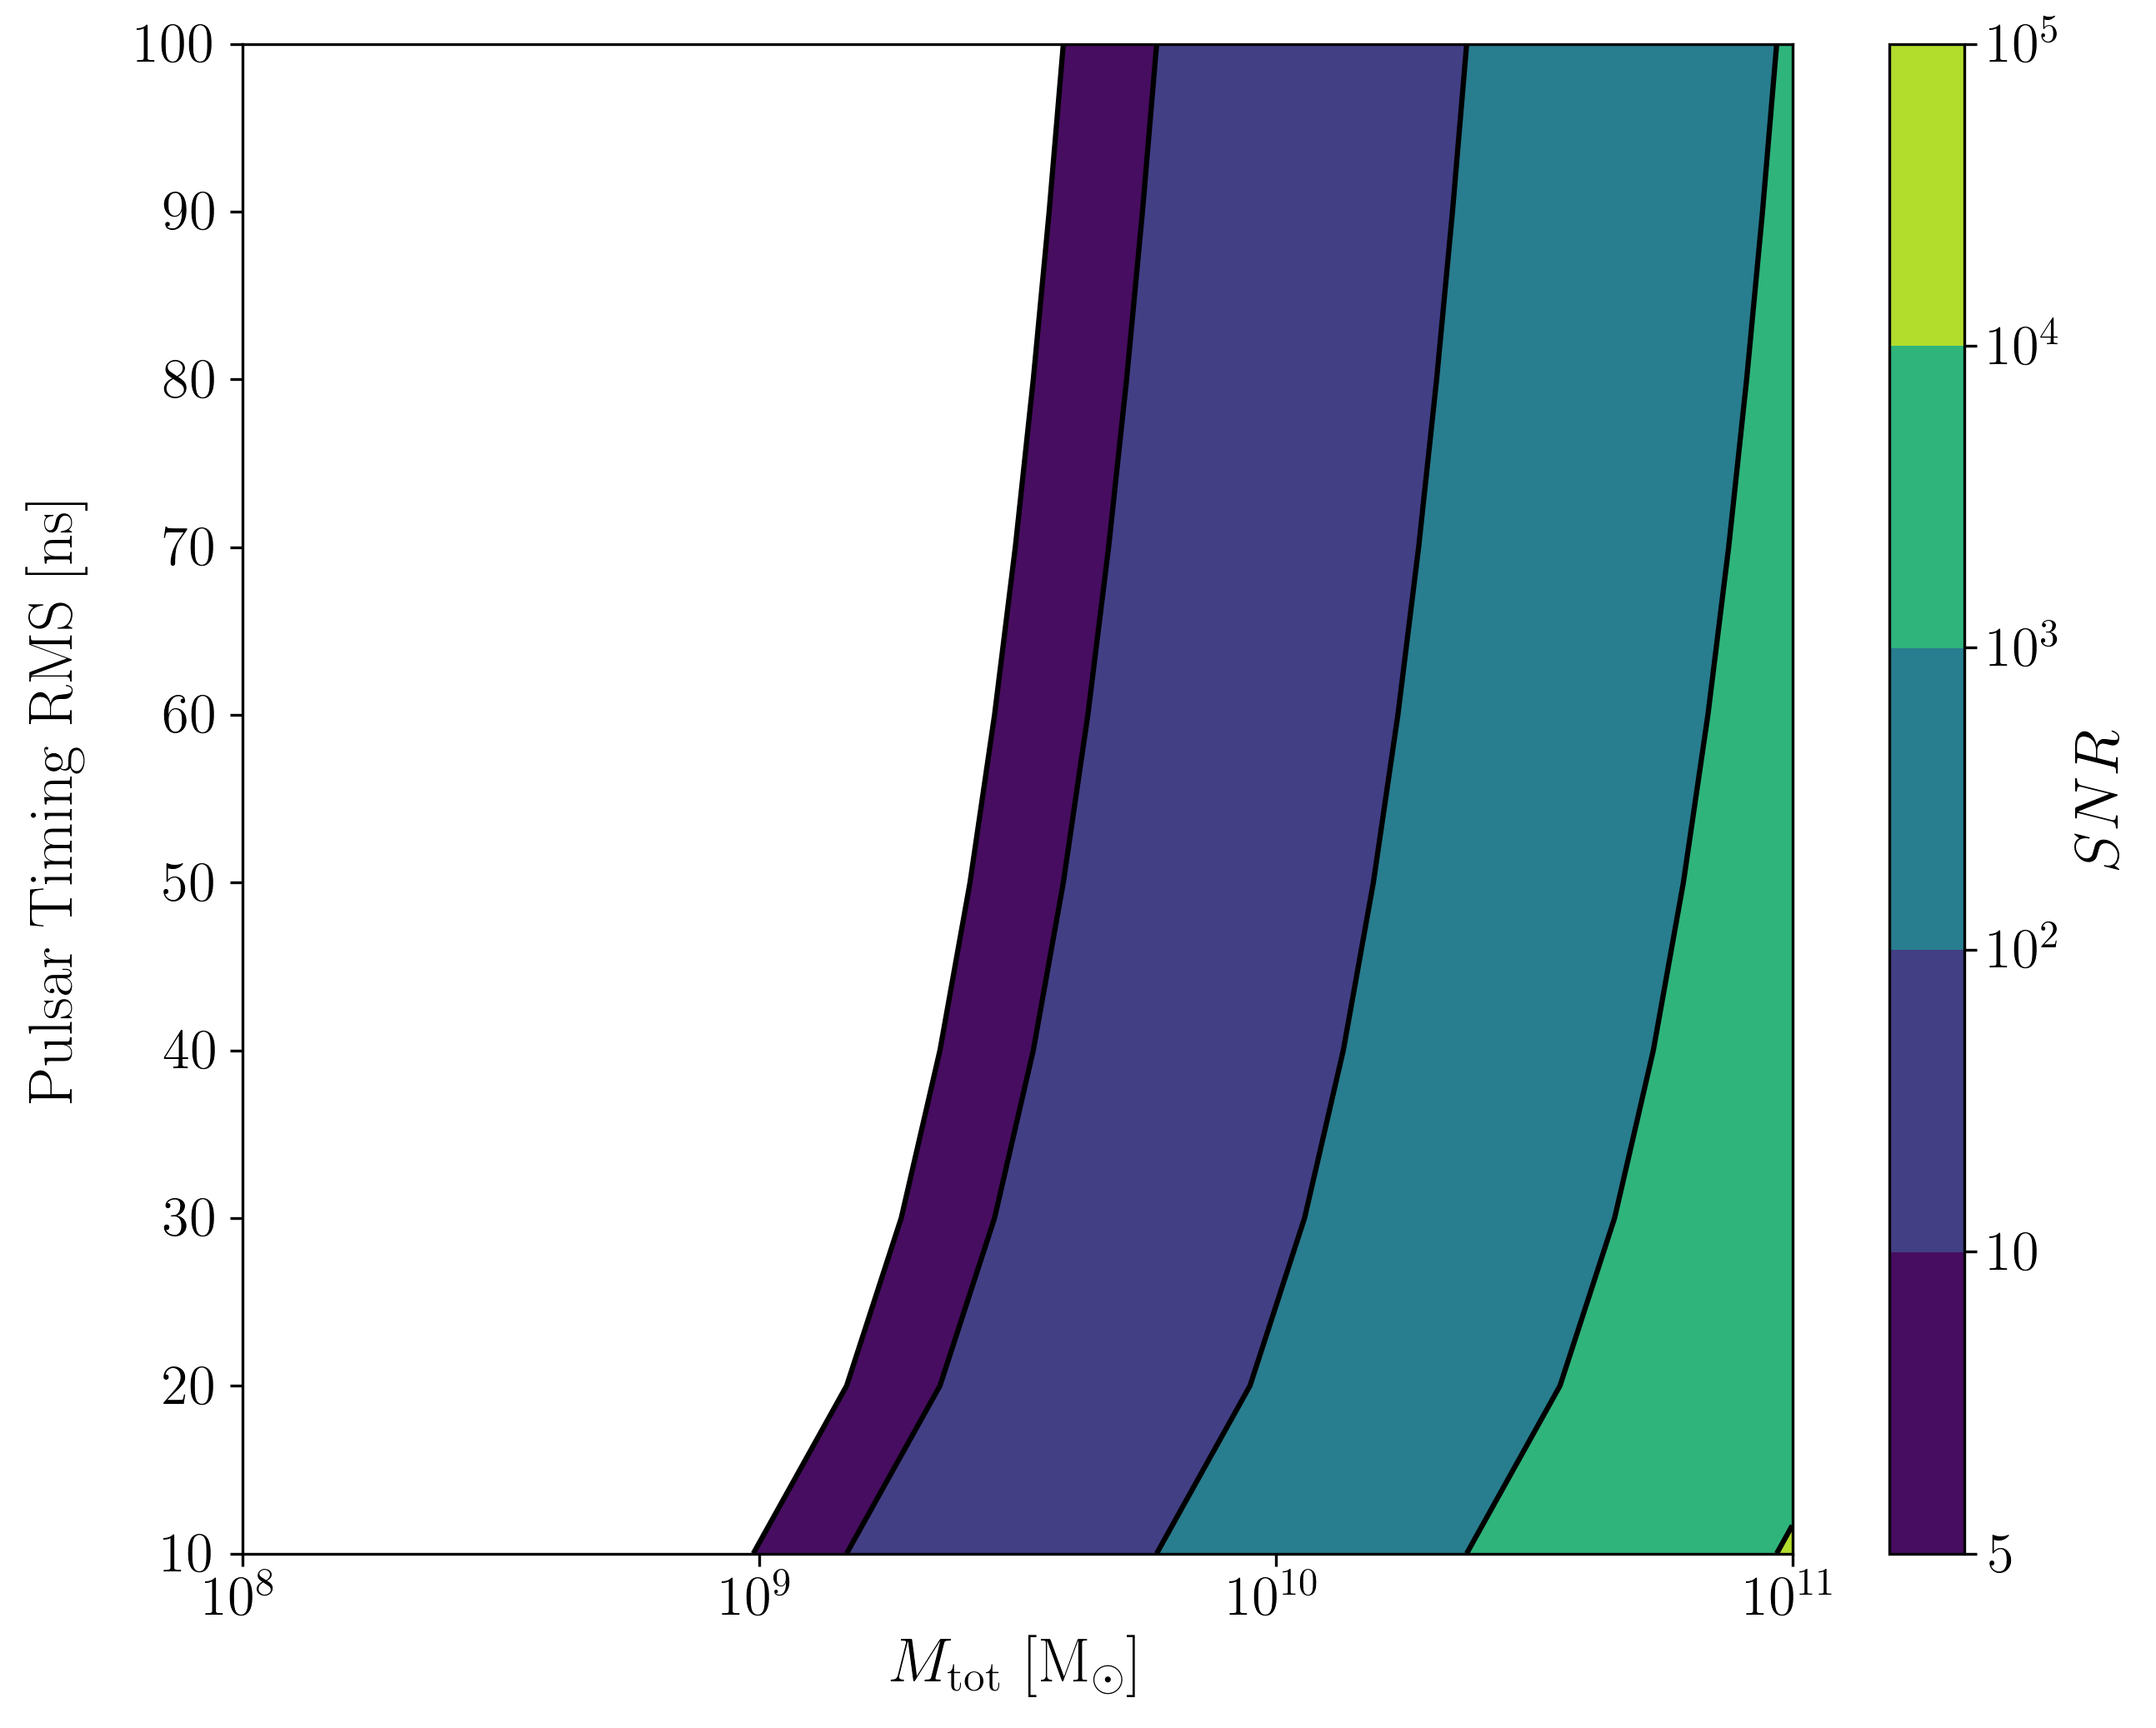

Model:  SKA_WN_M_vs_sigma ,  done. t = :  134.86095309257507


In [20]:
model = 5
instrument = Get_Instrument(model)
source = Get_Source(model)
start = time.time()
[sample_x,sample_y,SNRMatrix] = snr.Get_SNR_Matrix(source,instrument,
                                                   var_x,sampleRate_x,
                                                   var_y,sampleRate_y)
end = time.time()
snrplot.Plot_SNR(source,instrument,var_x,sample_x,var_y,sample_y,SNRMatrix,
                 dl_axis=False,smooth_contours=False)

print('Model: ',instrument.name + '_' + var_x + '_vs_' + var_y,',',' done. t = : ',end-start)

#### SKA Realistic Noise

In [21]:
#Variable on y-axis
var_y = 'T_obs'
#Variable on x-axis
var_x = 'M'

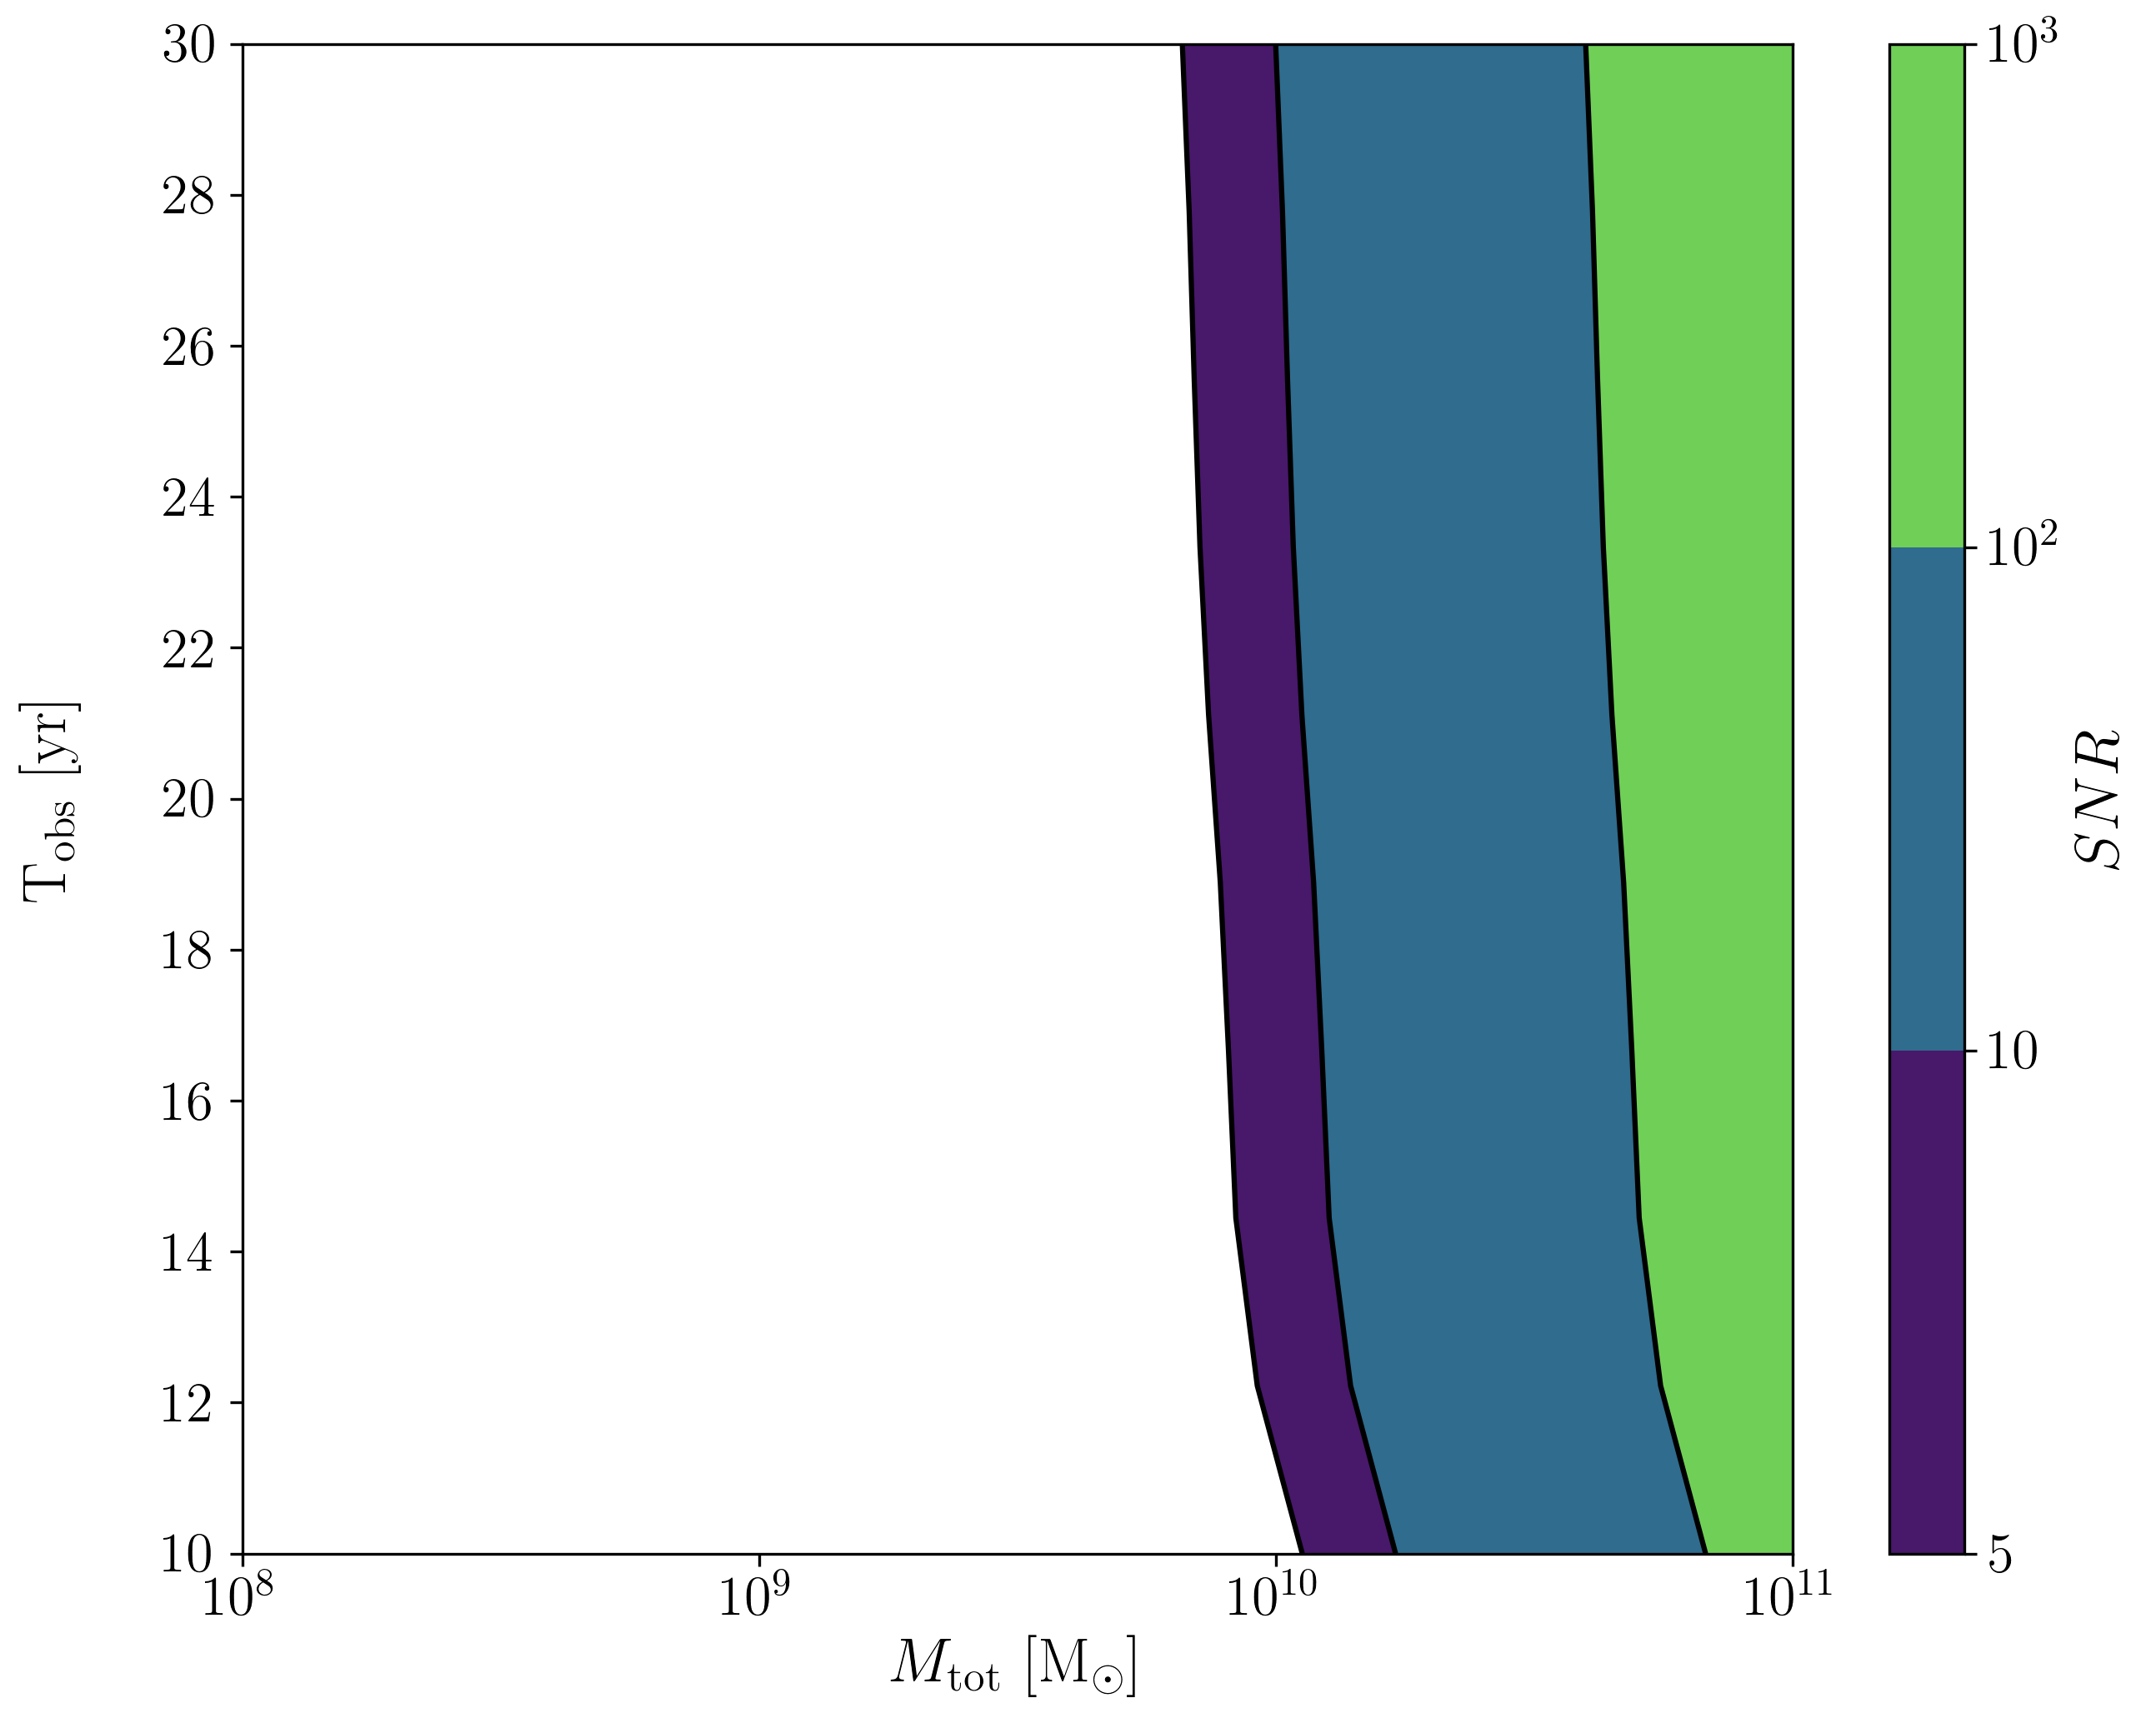

Model:  SKA_realistic_noise_M_vs_T_obs ,  done. t = :  324.45782709121704


In [22]:
model = 6
instrument = Get_Instrument(model)
source = Get_Source(model)
start = time.time()
[sample_x,sample_y,SNRMatrix] = snr.Get_SNR_Matrix(source,instrument,
                                                   var_x,sampleRate_x,
                                                   var_y,sampleRate_y)
end = time.time()
snrplot.Plot_SNR(source,instrument,var_x,sample_x,var_y,sample_y,SNRMatrix,
                 dl_axis=False,smooth_contours=False)

print('Model: ',instrument.name + '_' + var_x + '_vs_' + var_y,',',' done. t = : ',end-start)

### Space Based Instrument

#### LISA

In [23]:
#Number of SNRMatrix rows
sampleRate_y = 50
#Number of SNRMatrix columns
sampleRate_x = 50
#Variable on y-axis
var_ys = ['z','q','chi1','L','A_acc']
#Variable on x-axis
var_x = 'M'

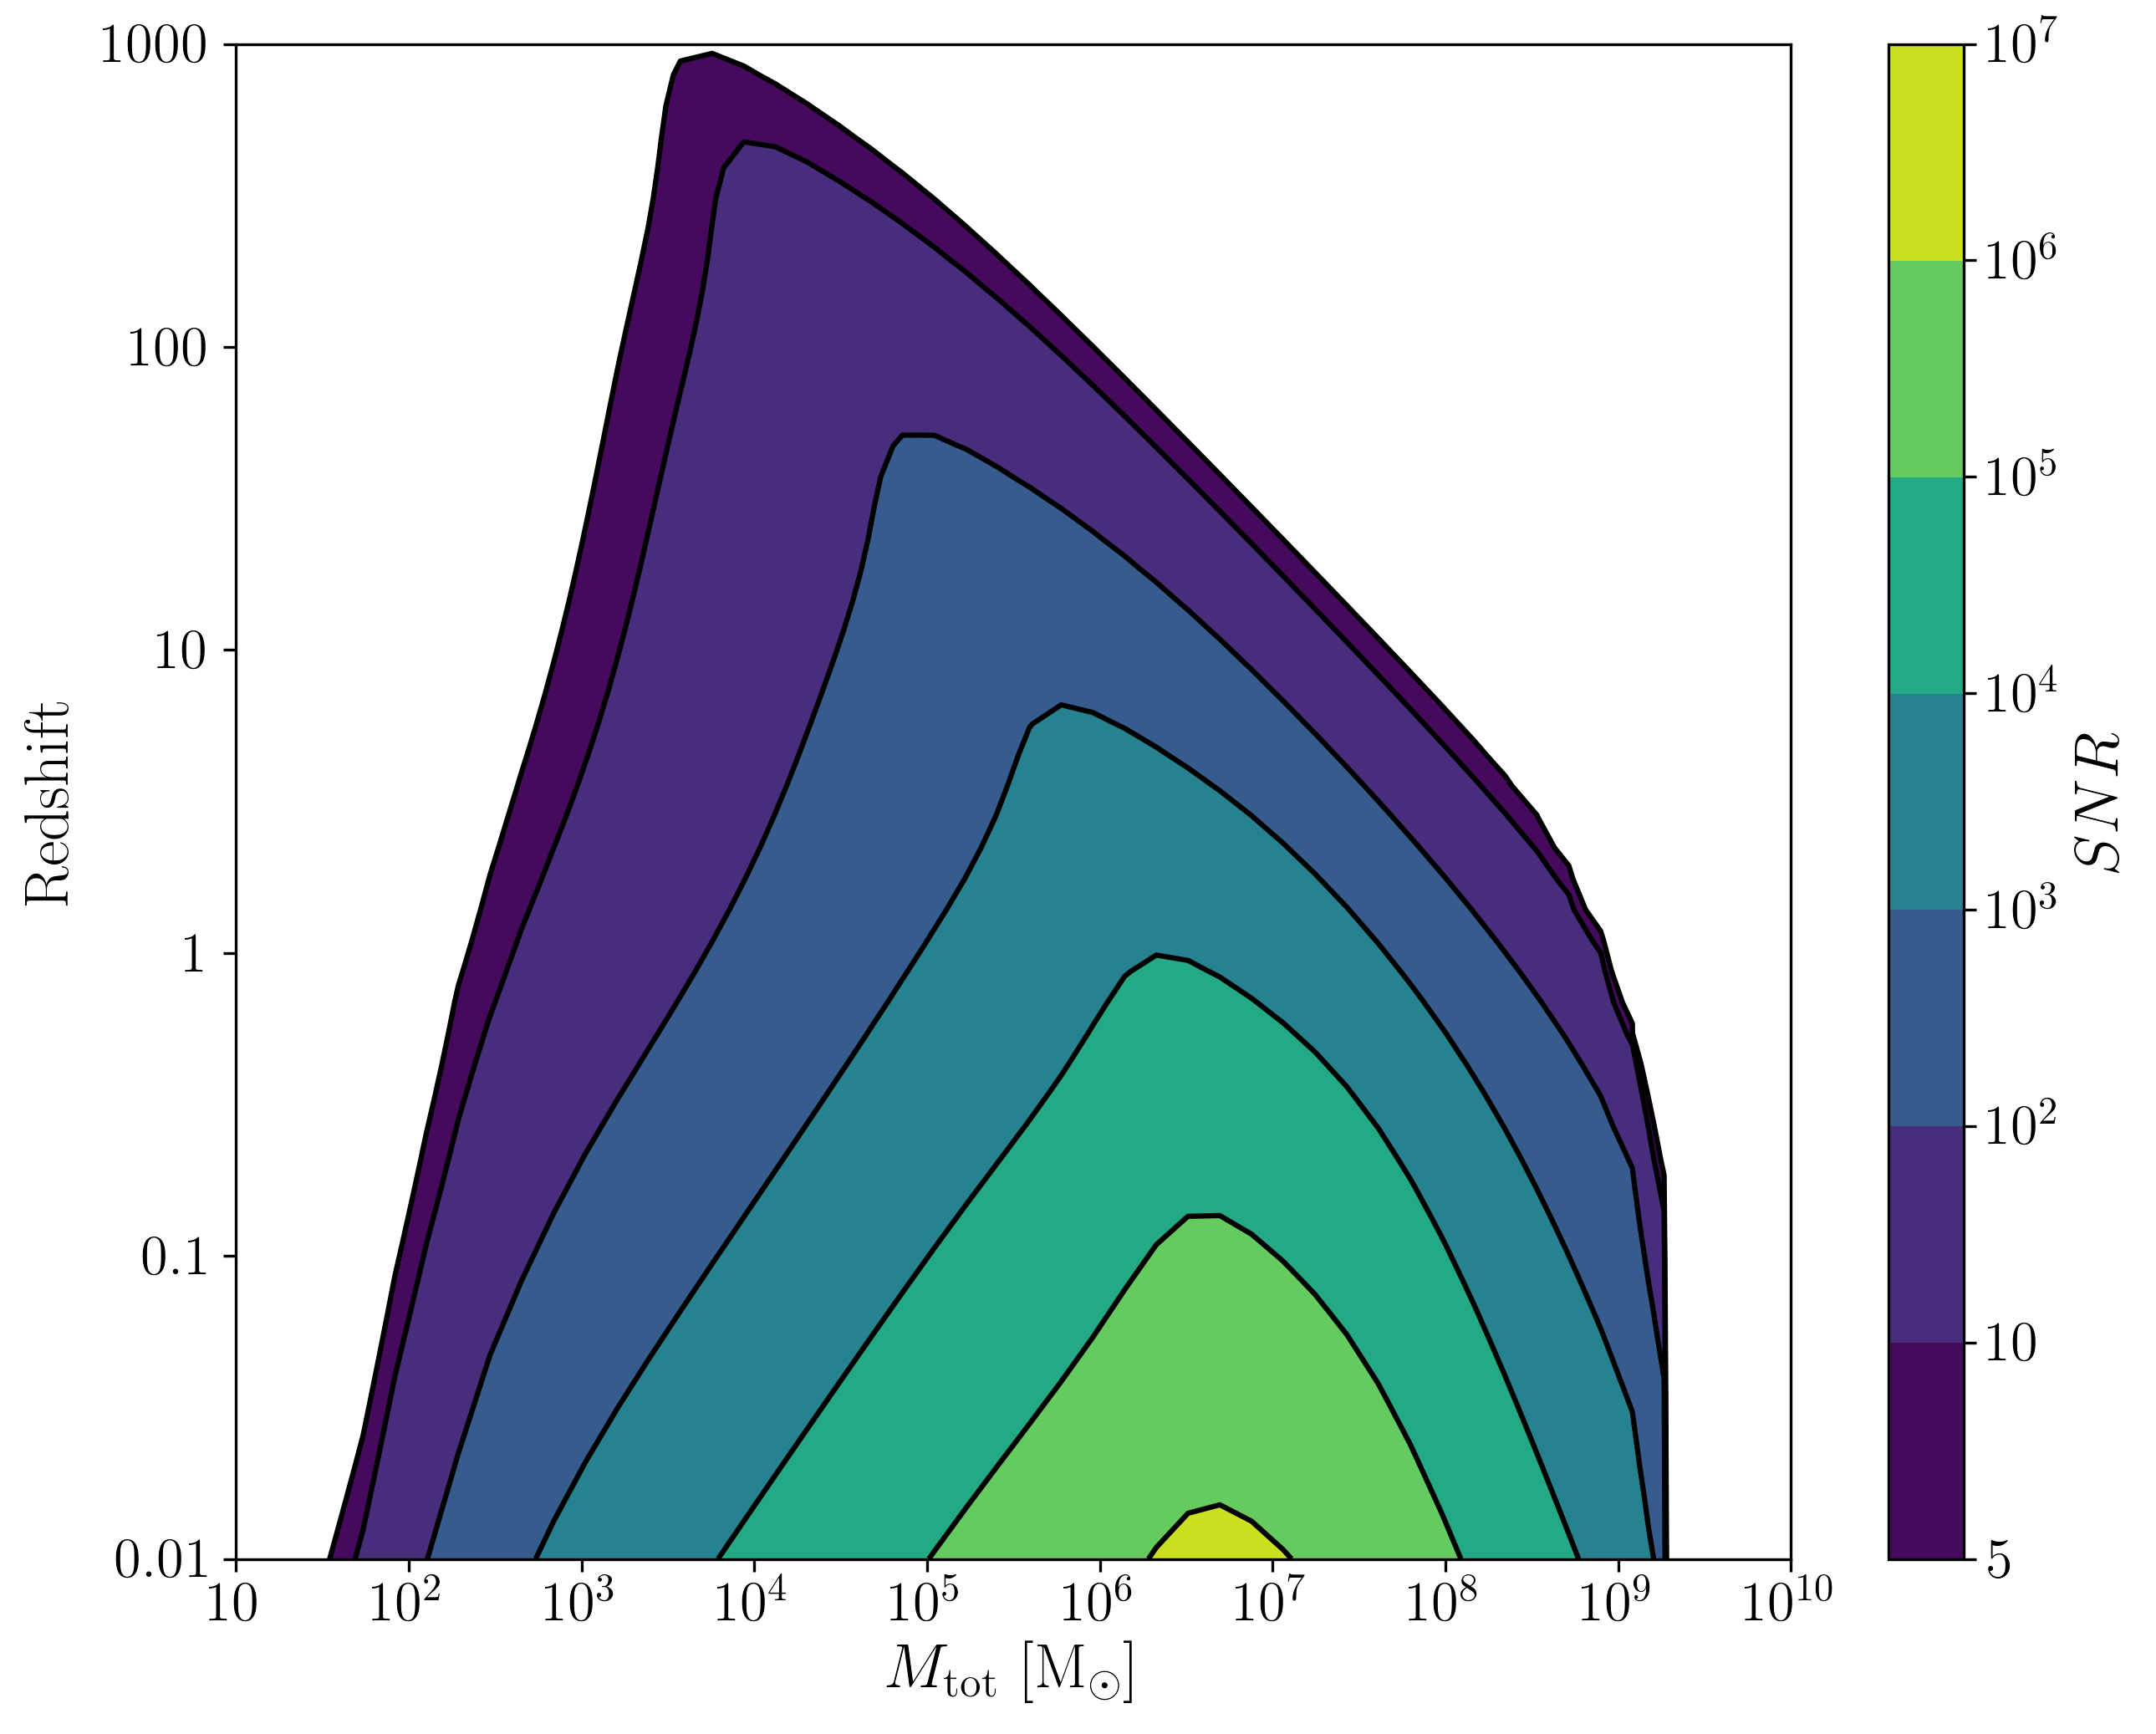

Model:  LISA_ESA_M_vs_z ,  done. t = :  23.79416799545288


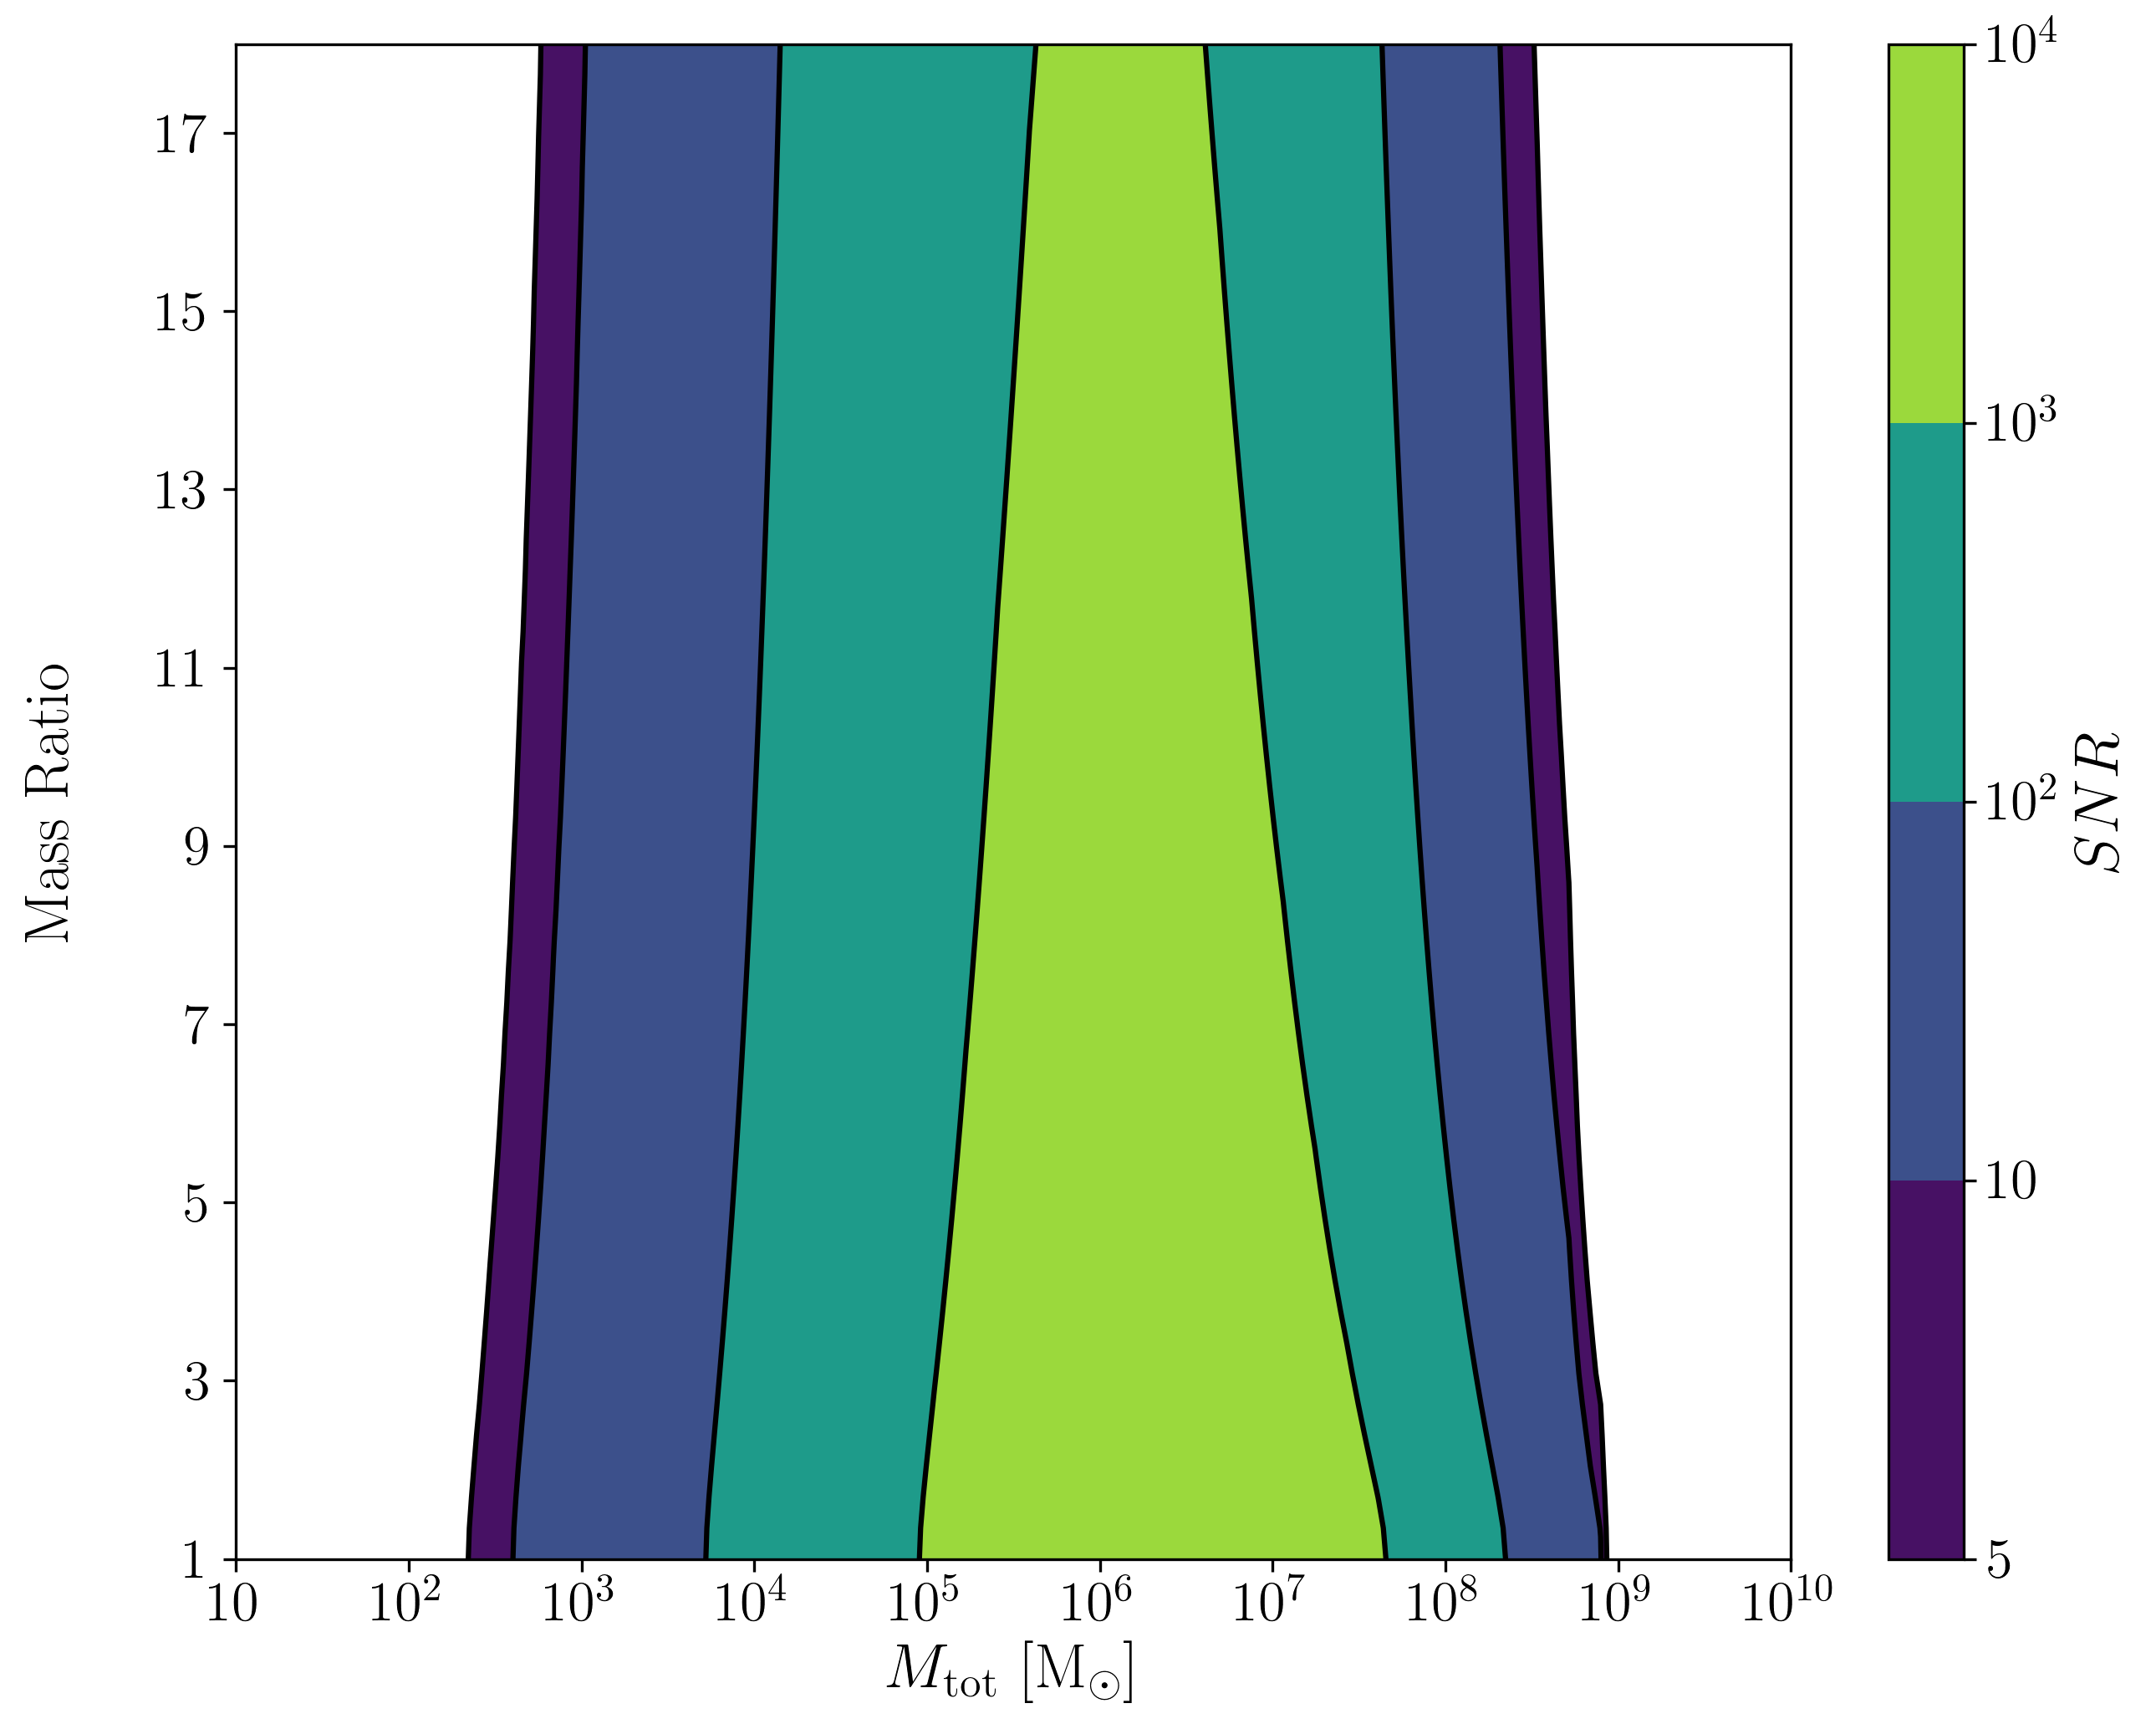

Model:  LISA_ESA_M_vs_q ,  done. t = :  28.552029132843018
here


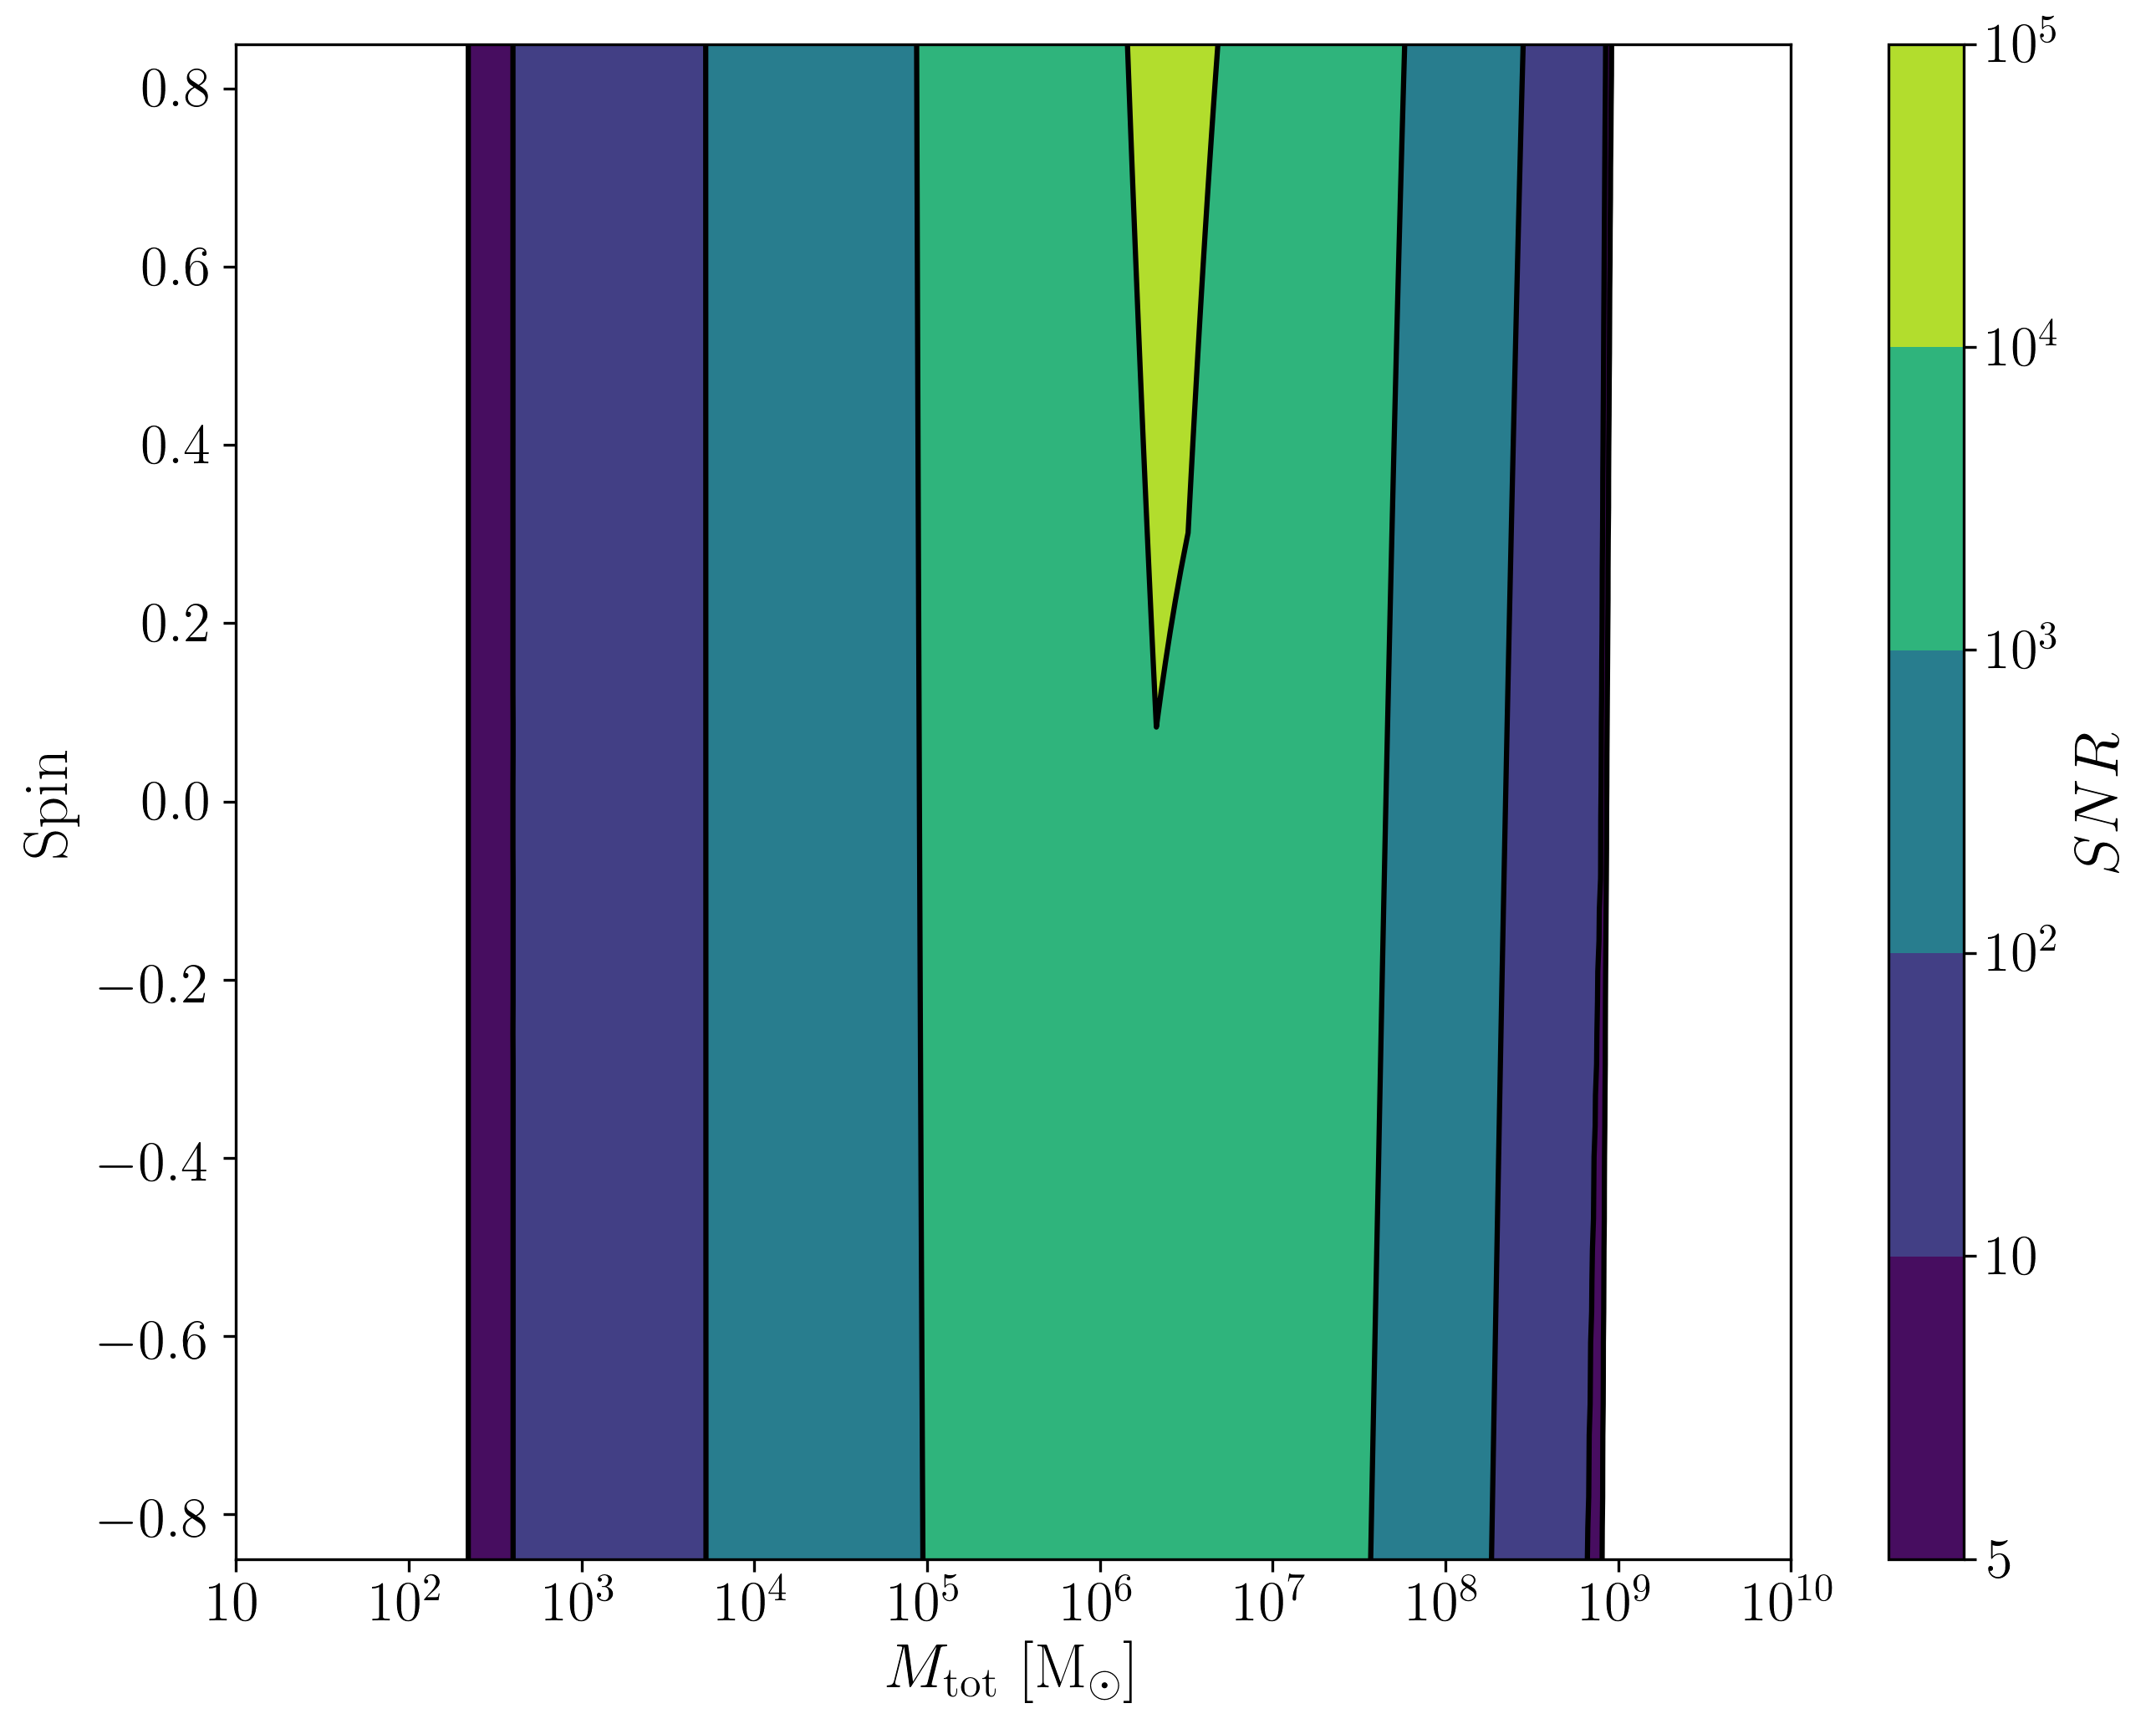

Model:  LISA_ESA_M_vs_chi1 ,  done. t = :  28.777315139770508


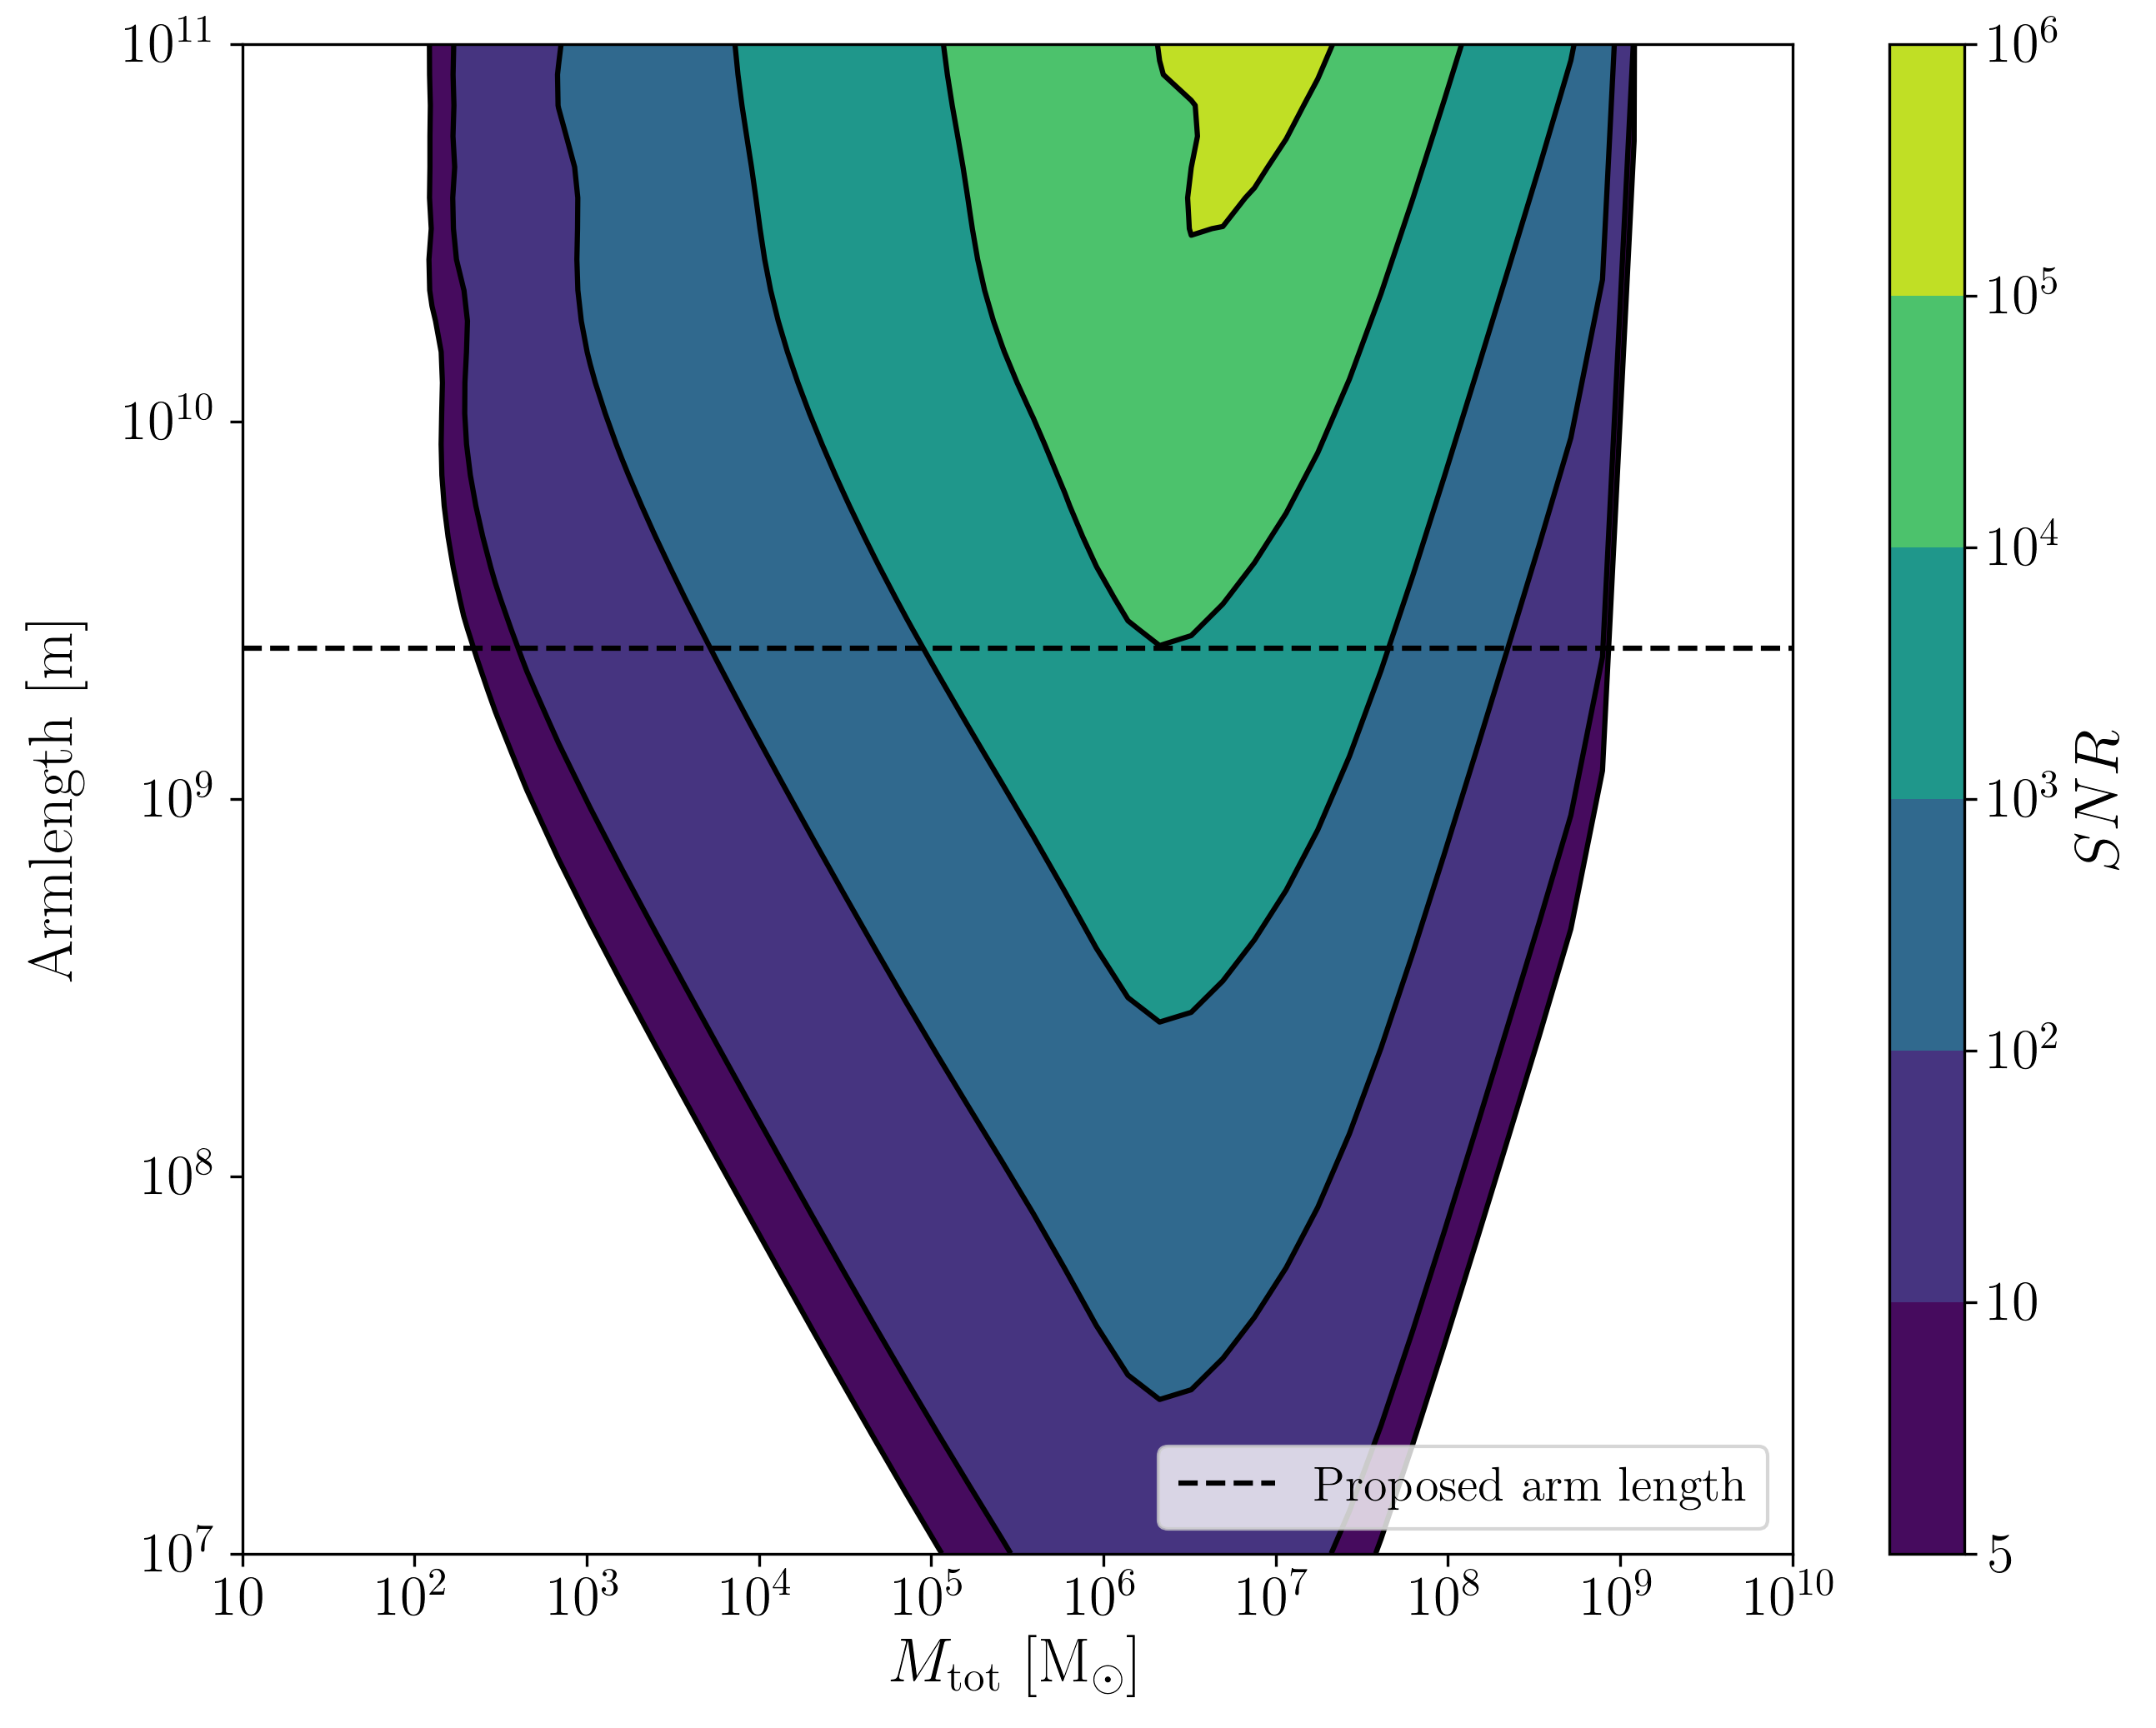

Model:  LISA_ESA_M_vs_L ,  done. t = :  22.928117990493774


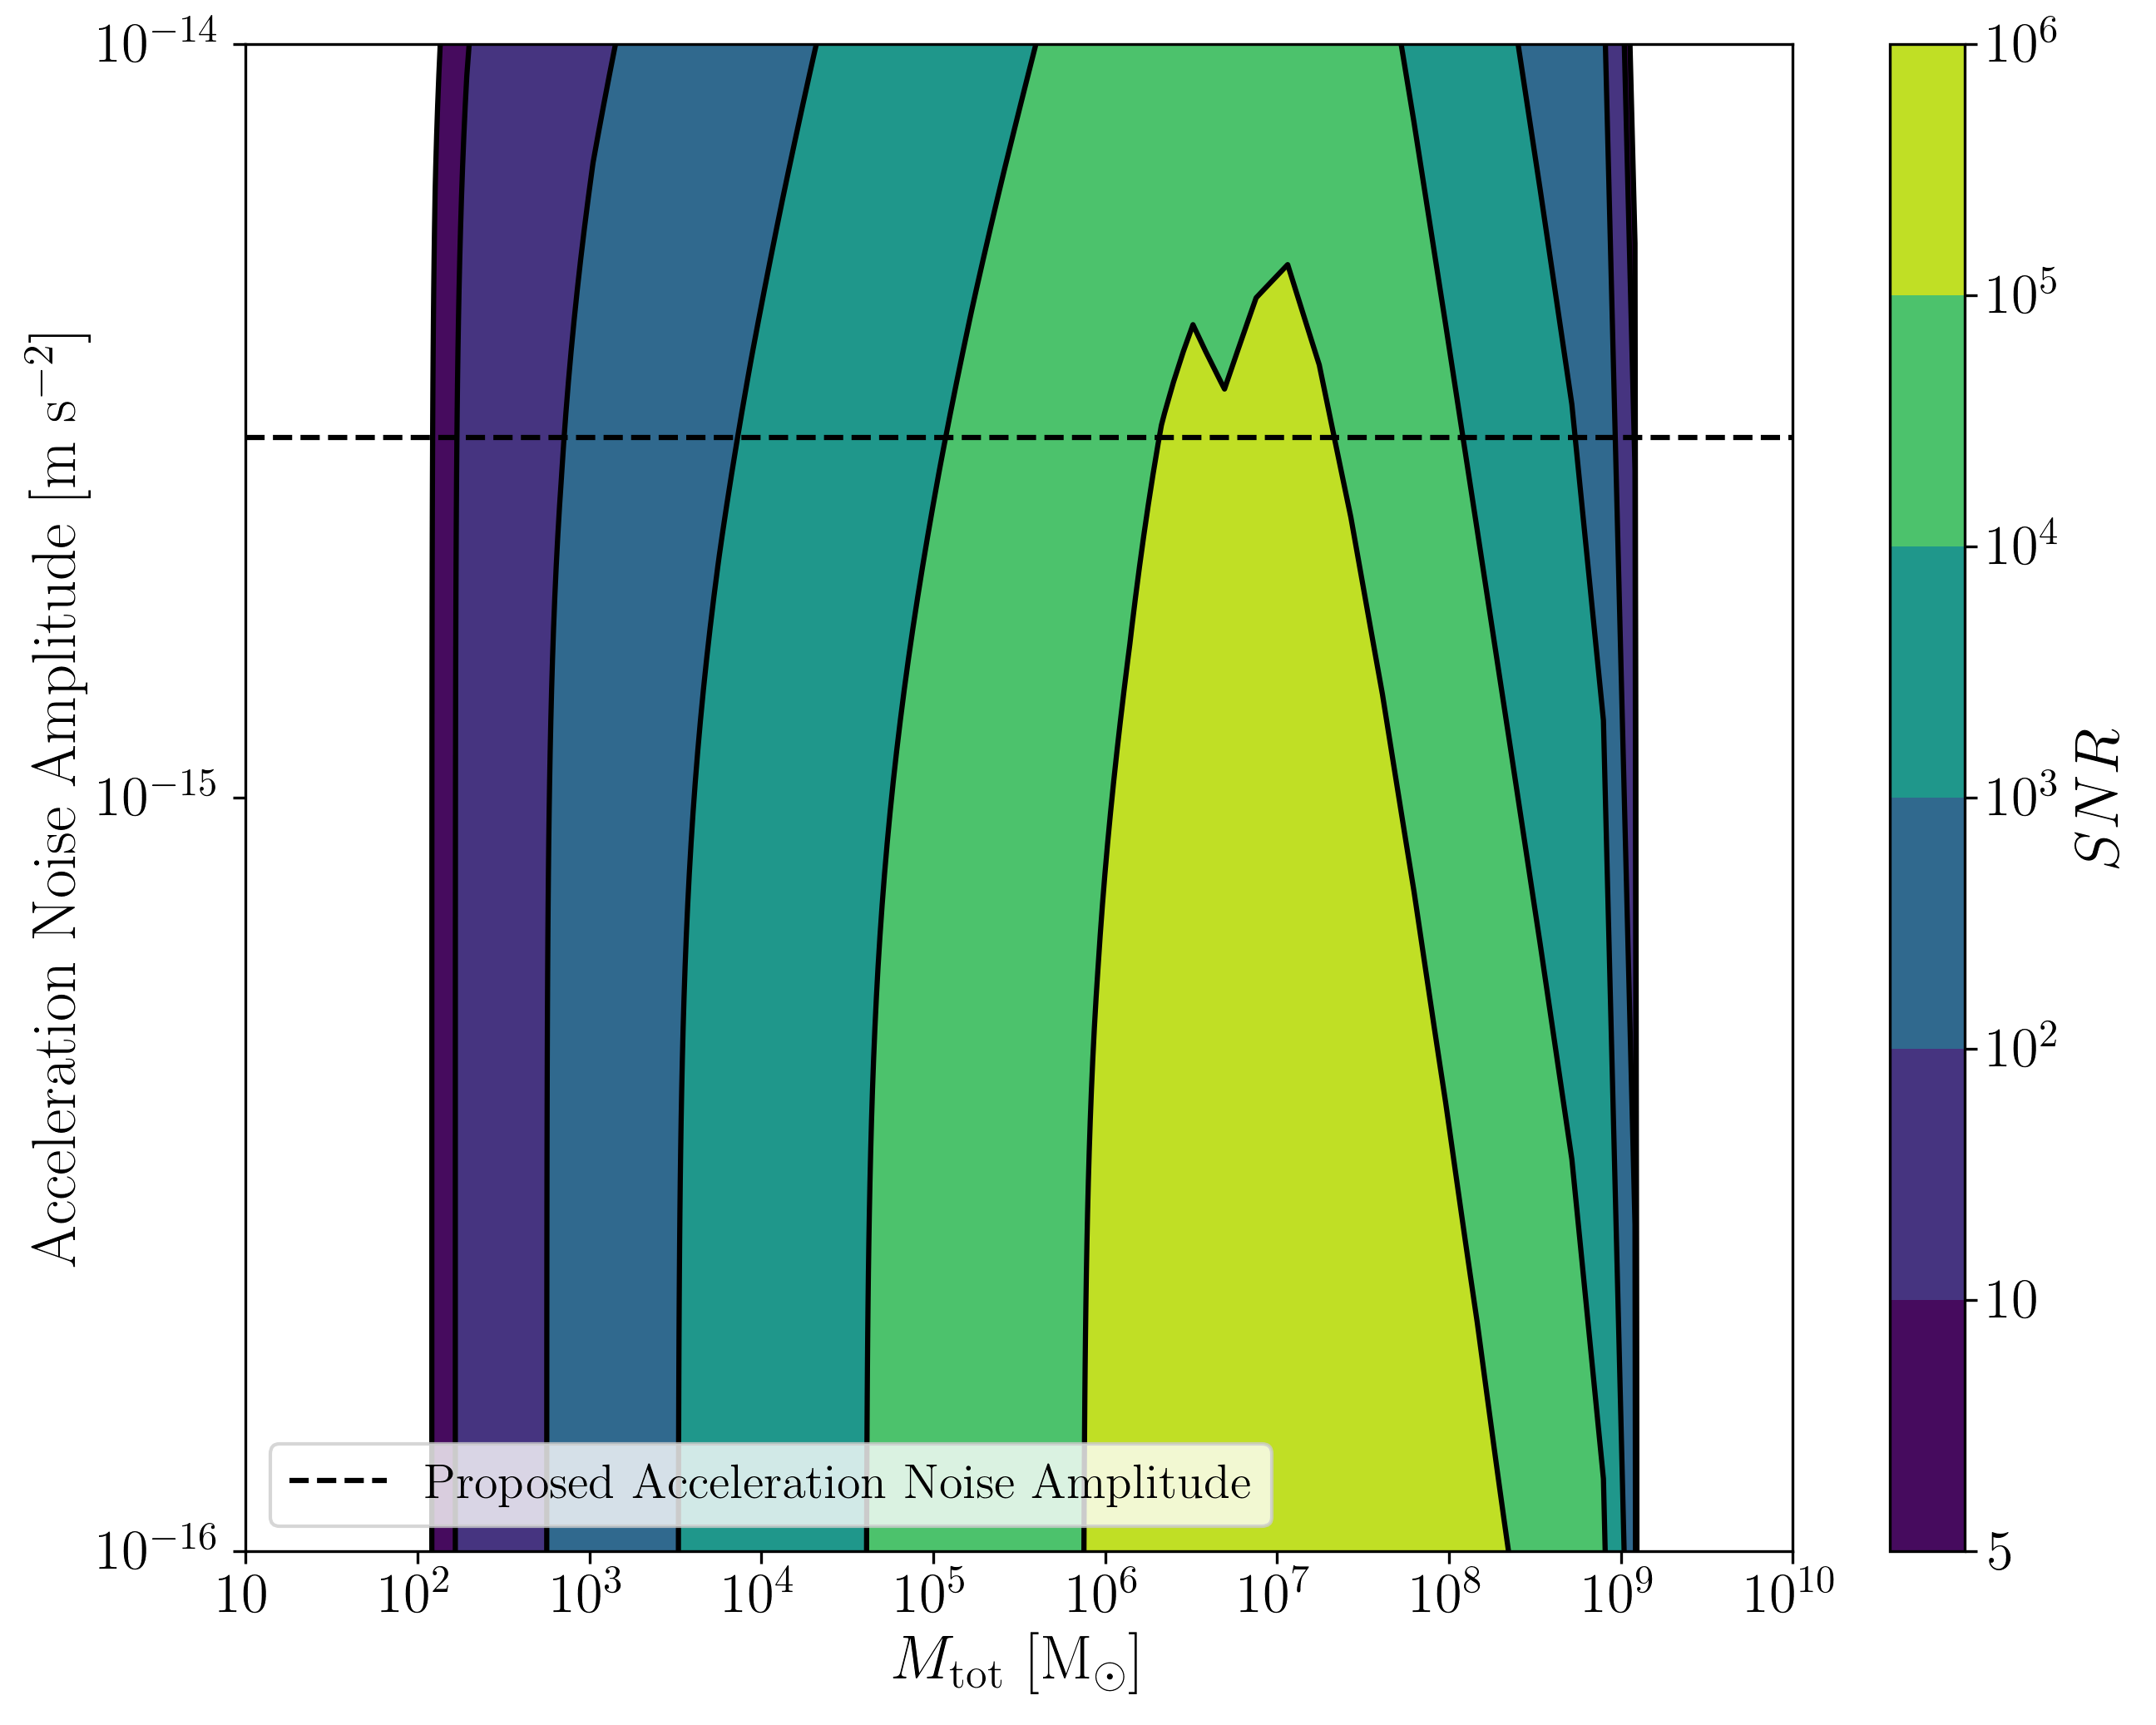

Model:  LISA_ESA_M_vs_A_acc ,  done. t = :  22.139339923858643


In [24]:
model = 7
instrument = Get_Instrument(model)
for var_y in var_ys:
    source = Get_Source(model)
    start = time.time()
    [sample_x,sample_y,SNRMatrix] = snr.Get_SNR_Matrix(source,instrument,
                                                       var_x,sampleRate_x,
                                                       var_y,sampleRate_y)
    end = time.time()
    snrplot.Plot_SNR(source,instrument,var_x,sample_x,var_y,sample_y,SNRMatrix,
                     dl_axis=False,smooth_contours=False)

    print('Model: ',instrument.name + '_' + var_x + '_vs_' + var_y,',',' done. t = : ',end-start)